In [1]:
import numpy as np
import pandas as pd
import numpy as np

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

# Gera dados aleatórios ao invés de um grid regular
def GetRandomSamples(n_samples):
    x = np.random.uniform(0, 1, n_samples)
    y = np.random.uniform(0, 1, n_samples)
    z = benchmark(x, y)
    return x, y, z

# Cria um DataFrame a partir dos pontos aleatórios
def create_random_dataframe(n_samples):
    x, y, z = GetRandomSamples(n_samples)
    data = {'x1': x, 'x2': y, 'f(x1,x2)': z}
    df = pd.DataFrame(data)
    return df

def GetGrid(grid):
    x = np.linspace(0, 1, grid)
    y = np.linspace(0, 1, grid)
    x, y = np.meshgrid(x, y)
    z = benchmark(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_training = create_random_dataframe(n_samples=30)   
df_test = create_random_dataframe(n_samples=20)       
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Power")

/tmp/ipykernel_22519/267132124.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


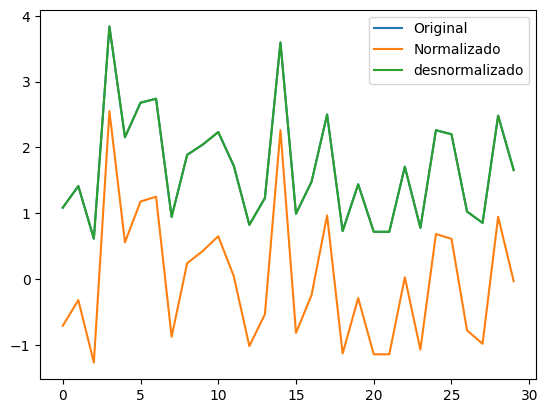

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 3.67 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-14 14:24:40.028747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 14:24:40.030868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 14:24:40.034175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 14:24:40.060877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 14:24:44.598690: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/ste

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.062181,-0.114983,-1.373870,-0.143450,0.342145,0.661902,0.536243,0.300592,0.290375,0.584932,-0.074083,0.589314,36.145039,85.534710
model_1_0_8,0.039406,-0.136813,-1.442136,-0.176568,0.350454,0.674861,0.551664,0.309298,0.292236,0.591992,-0.100167,0.596426,36.097050,85.486721
model_1_0_7,0.008265,-0.167022,-1.543477,-0.224398,0.361816,0.692795,0.574556,0.321872,0.294005,0.601511,-0.135834,0.606017,36.033240,85.422911
model_1_0_6,-0.029330,-0.203400,-1.672784,-0.284187,0.375532,0.714390,0.603766,0.337589,0.295541,0.612806,-0.178891,0.617397,35.958826,85.348497
model_1_0_5,-0.070024,-0.242015,-1.817430,-0.349855,0.390378,0.737314,0.636441,0.354852,0.297244,0.624802,-0.225498,0.629483,35.881280,85.270951
model_1_0_4,-0.089550,-0.262494,-1.965736,-0.399349,0.397501,0.749471,0.669942,0.367863,0.293098,0.630477,-0.247860,0.635200,35.845113,85.234785
model_1_0_3,-0.158482,-0.319265,-2.183115,-0.515808,0.422650,0.783173,0.719047,0.398478,0.291863,0.650116,-0.326809,0.654985,35.722421,85.112092
model_1_0_2,-0.194603,-0.324077,-2.265983,-0.510689,0.435828,0.786029,0.737766,0.397132,0.338025,0.660173,-0.368178,0.665118,35.661015,85.050686
model_1_0_0,-0.280454,-0.330237,-1.838261,-0.533524,0.467149,0.789686,0.641146,0.403135,0.373017,0.683483,-0.466503,0.688603,35.522212,84.911883
model_1_0_1,-0.270527,-0.340748,-1.873481,-0.520258,0.463528,0.795926,0.649102,0.399648,0.362474,0.680829,-0.455134,0.685929,35.537778,84.927449


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_1] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.428161,0.267849,-0.576664,0.420176,0.208624,0.434637,0.356159,0.115381,0.242372,0.456754,0.345074,0.460176,37.134439,86.524110
model_1_1_8,0.415140,0.245805,-0.460757,0.447933,0.213375,0.447723,0.329976,0.109857,0.243340,0.461925,0.330160,0.465386,37.089408,86.479079
model_1_1_4,0.359090,0.219632,-0.357062,0.387312,0.233824,0.463260,0.306552,0.121920,0.267435,0.483553,0.265967,0.487175,36.906376,86.296047
model_1_1_6,0.383943,0.211455,-0.514171,0.429071,0.224757,0.468114,0.342042,0.113611,0.247571,0.474085,0.294431,0.477636,36.985475,86.375146
model_1_1_5,0.376922,0.208617,-0.503061,0.421854,0.227318,0.469799,0.339532,0.115047,0.251017,0.476779,0.286389,0.480350,36.962808,86.352480
model_1_1_3,0.350082,0.208320,-0.392318,0.380611,0.237110,0.469976,0.314516,0.123254,0.267837,0.486940,0.255650,0.490587,36.878460,86.268132
model_1_1_7,0.386238,0.205573,-0.564615,0.430424,0.223919,0.471606,0.353437,0.113341,0.241808,0.473201,0.297059,0.476746,36.992939,86.382610
model_1_1_2,0.264853,0.108745,-0.749850,0.298170,0.268205,0.529087,0.395281,0.139659,0.272341,0.517885,0.158036,0.521764,36.632011,86.021682
model_1_1_1,0.181841,0.040866,-0.930336,0.192754,0.298490,0.569383,0.436051,0.160636,0.287539,0.546342,0.062964,0.550435,36.418040,85.807711
model_1_1_0,0.163635,0.025433,-0.708823,0.210965,0.305132,0.578545,0.386013,0.157012,0.303108,0.552387,0.042112,0.556525,36.374023,85.763694


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_2] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_6,0.621731,0.512641,0.183120,0.566011,0.138004,0.289317,0.184528,0.105412,0.219145,0.371489,0.566769,0.374272,37.960942,87.350614
model_1_2_5,0.614550,0.508867,0.180387,0.556154,0.140624,0.291558,0.185146,0.107806,0.222123,0.374999,0.558544,0.377808,37.923330,87.313001
model_1_2_4,0.610419,0.505351,0.173558,0.551893,0.142131,0.293645,0.186688,0.108841,0.223446,0.377003,0.553813,0.379827,37.902007,87.291679
model_1_2_9,0.653955,0.478960,-0.081863,0.651995,0.126248,0.309312,0.244386,0.084527,0.172980,0.355314,0.603675,0.357975,38.139014,87.528686
model_1_2_8,0.652472,0.477717,-0.083177,0.650687,0.126789,0.310050,0.244683,0.084845,0.174089,0.356075,0.601976,0.358742,38.130461,87.520132
model_1_2_7,0.650356,0.477142,-0.078355,0.648700,0.127561,0.310391,0.243594,0.085328,0.176089,0.357157,0.599554,0.359832,38.118324,87.507996
model_1_2_3,0.504302,0.474477,0.223129,0.365509,0.180846,0.311973,0.175491,0.154112,0.271120,0.425260,0.432277,0.428446,37.420217,86.809889
model_1_2_0,0.490144,0.339608,-0.350851,0.493489,0.186011,0.392037,0.305149,0.123027,0.233461,0.431290,0.416062,0.434521,37.363895,86.753566
model_1_2_2,0.520545,0.333526,-0.518533,0.540499,0.174920,0.395648,0.343027,0.111609,0.196966,0.418234,0.450881,0.421367,37.486853,86.876524
model_1_2_1,0.497050,0.314410,-0.545243,0.520173,0.183492,0.406996,0.349061,0.116546,0.208693,0.428359,0.423972,0.431568,37.391173,86.780844


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.796447,0.636978,0.245727,0.805131,0.074263,0.215506,0.170386,0.096576,0.136663,0.272511,0.766871,0.274553,39.200298,88.589969
model_1_3_8,0.784769,0.633856,0.270223,0.798330,0.078523,0.217359,0.164852,0.099947,0.146425,0.280220,0.753496,0.282319,39.088726,88.478397
model_1_3_7,0.782590,0.631519,0.266447,0.796036,0.079318,0.218746,0.165705,0.101083,0.147398,0.281634,0.751000,0.283744,39.068582,88.458253
model_1_3_6,0.765222,0.613923,0.230682,0.780870,0.085654,0.229192,0.173784,0.108600,0.154855,0.292668,0.731109,0.294860,38.914870,88.304541
model_1_3_5,0.762516,0.610542,0.222667,0.778053,0.086641,0.231199,0.175595,0.109996,0.155729,0.294349,0.728010,0.296554,38.891954,88.281625
model_1_3_4,0.759620,0.607351,0.216183,0.774957,0.087698,0.233093,0.177060,0.111530,0.156837,0.296138,0.724693,0.298357,38.867713,88.257384
model_1_3_3,0.749122,0.597824,0.238254,0.747874,0.091528,0.238749,0.172074,0.124952,0.162551,0.302536,0.712669,0.304802,38.782218,88.171889
model_1_3_2,0.711106,0.553634,0.136560,0.702673,0.105398,0.264982,0.195046,0.147353,0.169406,0.324650,0.669130,0.327082,38.500031,87.889702
model_1_3_1,0.707825,0.551753,0.137252,0.699646,0.106594,0.266099,0.194889,0.148854,0.171448,0.326488,0.665373,0.328934,38.477449,87.867121
model_1_3_0,0.656538,0.481091,-0.080059,0.652122,0.125305,0.308047,0.243979,0.172407,0.171651,0.353985,0.606634,0.356637,38.154002,87.543673


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.856656,0.712066,0.339824,0.851612,0.052297,0.170930,0.149130,0.068932,0.111071,0.228684,0.835828,0.230397,39.901651,89.291323
model_1_4_8,0.852589,0.708080,0.336365,0.848557,0.053780,0.173296,0.149911,0.070351,0.113559,0.231906,0.831170,0.233643,39.845698,89.235370
model_1_4_7,0.845208,0.689587,0.315100,0.850356,0.056473,0.184274,0.154715,0.069516,0.113550,0.237640,0.822717,0.239421,39.747985,89.137657
model_1_4_5,0.834777,0.682496,0.309656,0.840198,0.060278,0.188484,0.155945,0.074235,0.120325,0.245517,0.810771,0.247356,39.617563,89.007235
model_1_4_6,0.838407,0.682274,0.290634,0.844279,0.058954,0.188616,0.160241,0.072339,0.116661,0.242805,0.814928,0.244623,39.661994,89.051665
model_1_4_4,0.829996,0.676176,0.302716,0.837788,0.062023,0.192236,0.157512,0.075354,0.122053,0.249044,0.805294,0.250909,39.560503,88.950175
model_1_4_3,0.828930,0.675508,0.302553,0.836919,0.062412,0.192632,0.157549,0.075758,0.122709,0.249823,0.804074,0.251694,39.548009,88.937680
model_1_4_2,0.817103,0.663107,0.289333,0.829741,0.066727,0.199994,0.160535,0.079092,0.128672,0.258315,0.790528,0.260250,39.414304,88.803975
model_1_4_1,0.799451,0.644157,0.251240,0.818357,0.073166,0.211244,0.169140,0.084381,0.136276,0.270493,0.770312,0.272519,39.230040,88.619711
model_1_4_0,0.797637,0.641841,0.246663,0.817372,0.073828,0.212619,0.170174,0.084838,0.136939,0.271714,0.768234,0.273749,39.212025,88.601697


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_5] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.868430,0.726943,0.356628,0.781607,0.048001,0.162099,0.145334,0.081403,0.105088,0.219091,0.849313,0.220732,40.073079,89.462750
model_1_5_8,0.868101,0.726260,0.355284,0.781073,0.048121,0.162504,0.145637,0.081602,0.105195,0.219365,0.848936,0.221008,40.068075,89.457746
model_1_5_6,0.865189,0.722909,0.349168,0.782448,0.049183,0.164493,0.147019,0.081089,0.106820,0.221773,0.845601,0.223434,40.024409,89.414081
model_1_5_7,0.865454,0.722909,0.349233,0.781733,0.049087,0.164493,0.147004,0.081356,0.106599,0.221555,0.845905,0.223214,40.028342,89.418013
model_1_5_5,0.864856,0.722312,0.348061,0.782124,0.049305,0.164848,0.147269,0.081210,0.106950,0.222047,0.845219,0.223710,40.019464,89.409135
model_1_5_4,0.862043,0.716812,0.337793,0.777612,0.050331,0.168113,0.149589,0.082892,0.107833,0.224346,0.841998,0.226026,39.978270,89.367941
model_1_5_3,0.861653,0.716374,0.336716,0.777634,0.050473,0.168372,0.149832,0.082884,0.108030,0.224662,0.841552,0.226345,39.972628,89.362299
model_1_5_2,0.861176,0.715332,0.334766,0.776603,0.050647,0.168991,0.150272,0.083268,0.108140,0.225049,0.841005,0.226735,39.965745,89.355416
model_1_5_0,0.857019,0.712779,0.340579,0.783743,0.052164,0.170507,0.148959,0.080607,0.110954,0.228395,0.836243,0.230105,39.906723,89.296394
model_1_5_1,0.858505,0.709640,0.328483,0.772303,0.051622,0.172370,0.151692,0.084871,0.108881,0.227205,0.837945,0.228907,39.927617,89.317288


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_6] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.881509,0.761037,0.521417,0.878339,0.043229,0.141859,0.108109,0.052432,0.105582,0.207916,0.864293,0.209473,40.282484,89.672156
model_1_6_8,0.880701,0.759639,0.513880,0.880885,0.043524,0.142689,0.109812,0.051335,0.106093,0.208624,0.863367,0.210186,40.268894,89.658566
model_1_6_7,0.880427,0.759081,0.511925,0.880764,0.043624,0.143020,0.110253,0.051387,0.106183,0.208864,0.863053,0.210428,40.264293,89.653965
model_1_6_6,0.880153,0.759006,0.511881,0.881059,0.043724,0.143064,0.110263,0.051260,0.106407,0.209103,0.862739,0.210669,40.259719,89.649390
model_1_6_5,0.876321,0.750878,0.496774,0.874064,0.045122,0.147889,0.113676,0.054275,0.107642,0.212419,0.858350,0.214010,40.196772,89.586443
model_1_6_1,0.875071,0.746479,0.439674,0.881791,0.045578,0.150501,0.126574,0.050944,0.105978,0.213490,0.856919,0.215089,40.176663,89.566334
model_1_6_2,0.875641,0.746410,0.441836,0.880951,0.045370,0.150542,0.126086,0.051307,0.105637,0.213002,0.857572,0.214598,40.185815,89.575487
model_1_6_4,0.876519,0.745303,0.442705,0.877808,0.045050,0.151199,0.125890,0.052661,0.104789,0.212249,0.858577,0.213839,40.199978,89.589649
model_1_6_3,0.876096,0.744479,0.439404,0.877536,0.045204,0.151688,0.126635,0.052778,0.104890,0.212612,0.858093,0.214205,40.193136,89.582808
model_1_6_0,0.867623,0.724474,0.354472,0.864605,0.048295,0.163564,0.145821,0.058351,0.104958,0.219762,0.848389,0.221408,40.060847,89.450518


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.887599,0.770147,0.522645,0.895048,0.041007,0.136451,0.107832,0.035906,0.102003,0.202503,0.871267,0.204019,40.388011,89.777682
model_1_7_8,0.887292,0.769722,0.521523,0.894525,0.041119,0.136703,0.108085,0.036086,0.102125,0.202779,0.870915,0.204298,40.382549,89.772220
model_1_7_7,0.887097,0.769239,0.520997,0.894359,0.041190,0.136989,0.108204,0.036142,0.102199,0.202954,0.870693,0.204475,40.379099,89.768770
model_1_7_6,0.886928,0.768938,0.523299,0.894212,0.041252,0.137168,0.107684,0.036193,0.102391,0.203107,0.870498,0.204628,40.376094,89.765765
model_1_7_4,0.886009,0.768891,0.518403,0.892101,0.041588,0.137196,0.108790,0.036915,0.102872,0.203930,0.869446,0.205458,40.359910,89.749581
model_1_7_5,0.886717,0.768478,0.522742,0.894003,0.041329,0.137441,0.107810,0.036264,0.102462,0.203296,0.870257,0.204819,40.372370,89.762041
model_1_7_3,0.885892,0.768022,0.523706,0.892387,0.041630,0.137712,0.107592,0.036817,0.103048,0.204035,0.869312,0.205563,40.357853,89.747525
model_1_7_2,0.885413,0.767324,0.523348,0.891741,0.041805,0.138127,0.107673,0.037038,0.103275,0.204463,0.868763,0.205994,40.349480,89.739152
model_1_7_1,0.884922,0.766674,0.521759,0.891007,0.041984,0.138512,0.108032,0.037289,0.103511,0.204900,0.868201,0.206435,40.340925,89.730596
model_1_7_0,0.882945,0.763654,0.517337,0.888528,0.042705,0.140305,0.109031,0.038137,0.104546,0.206652,0.865937,0.208200,40.306867,89.696538


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_6,0.890335,0.775417,0.520510,0.912790,0.040009,0.133322,0.108314,0.024681,0.100495,0.200023,0.874401,0.201521,40.437292,89.826963
model_1_8_5,0.890234,0.775412,0.519687,0.913315,0.040046,0.133325,0.108500,0.024532,0.100560,0.200115,0.874285,0.201614,40.435450,89.825122
model_1_8_9,0.890572,0.775098,0.517598,0.907885,0.039923,0.133511,0.108972,0.026069,0.100088,0.199807,0.874672,0.201304,40.441612,89.831283
model_1_8_7,0.890297,0.774917,0.518278,0.911808,0.040023,0.133619,0.108818,0.024959,0.100389,0.200058,0.874357,0.201556,40.436596,89.826268
model_1_8_8,0.890468,0.774777,0.516985,0.907874,0.039961,0.133702,0.109110,0.026072,0.100114,0.199901,0.874553,0.201399,40.439723,89.829394
model_1_8_1,0.888926,0.774573,0.520661,0.916688,0.040523,0.133823,0.108280,0.023578,0.101618,0.201303,0.872788,0.202811,40.411768,89.801439
model_1_8_4,0.889098,0.773814,0.515166,0.915367,0.040461,0.134274,0.109521,0.023952,0.101125,0.201148,0.872984,0.202655,40.414857,89.804529
model_1_8_3,0.888960,0.773493,0.514276,0.915445,0.040511,0.134464,0.109722,0.023929,0.101154,0.201273,0.872826,0.202780,40.412378,89.802049
model_1_8_0,0.888140,0.773358,0.518359,0.917598,0.040810,0.134544,0.108800,0.023320,0.101981,0.202015,0.871886,0.203528,40.397651,89.787322
model_1_8_2,0.888847,0.773230,0.515023,0.915754,0.040552,0.134621,0.109553,0.023842,0.101239,0.201375,0.872697,0.202884,40.410339,89.800011


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_9] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_6,0.893275,0.781218,0.545832,0.849813,0.038937,0.129878,0.102594,0.031471,0.100507,0.197324,0.877768,0.198802,40.491638,89.881309
model_1_9_5,0.893236,0.781103,0.545188,0.849908,0.038951,0.129947,0.102739,0.031452,0.100493,0.197360,0.877723,0.198838,40.490906,89.880577
model_1_9_8,0.893330,0.780542,0.549273,0.847373,0.038916,0.130280,0.101817,0.031983,0.100606,0.197272,0.877831,0.198750,40.492678,89.882349
model_1_9_9,0.893335,0.780535,0.549799,0.846998,0.038915,0.130284,0.101698,0.032061,0.100627,0.197268,0.877837,0.198745,40.492775,89.882446
model_1_9_7,0.893306,0.780480,0.548706,0.847509,0.038925,0.130317,0.101944,0.031954,0.100589,0.197295,0.877804,0.198772,40.492229,89.881900
model_1_9_4,0.892799,0.779999,0.538580,0.850758,0.039110,0.130602,0.104232,0.031274,0.100320,0.197763,0.877223,0.199245,40.482741,89.872413
model_1_9_3,0.892439,0.779083,0.538434,0.851735,0.039242,0.131146,0.104265,0.031069,0.100330,0.198095,0.876811,0.199579,40.476040,89.865711
model_1_9_2,0.892026,0.778380,0.534521,0.852580,0.039392,0.131563,0.105149,0.030892,0.100280,0.198475,0.876338,0.199961,40.468375,89.858047
model_1_9_1,0.891006,0.776345,0.519475,0.852873,0.039764,0.132771,0.108548,0.030830,0.100087,0.199410,0.875169,0.200904,40.449569,89.839240
model_1_9_0,0.890737,0.775324,0.518925,0.852415,0.039862,0.133377,0.108672,0.030926,0.100093,0.199656,0.874862,0.201151,40.444645,89.834316


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_1,0.892997,0.784768,0.594921,0.897174,0.039038,0.127771,0.091505,0.063009,0.101586,0.197581,0.877449,0.199061,40.486436,89.876107
model_1_10_2,0.892756,0.784756,0.602902,0.894170,0.039126,0.127778,0.089702,0.064850,0.101443,0.197802,0.877174,0.199284,40.481948,89.871619
model_1_10_3,0.894004,0.784107,0.589973,0.894139,0.038670,0.128163,0.092623,0.064868,0.100102,0.196648,0.878603,0.198121,40.505358,89.895029
model_1_10_5,0.893799,0.783152,0.594221,0.890988,0.038745,0.128730,0.091663,0.066800,0.099585,0.196838,0.878368,0.198313,40.501487,89.891158
model_1_10_4,0.893545,0.782406,0.598474,0.890450,0.038838,0.129173,0.090702,0.067129,0.099693,0.197073,0.878078,0.198550,40.496716,89.886387
model_1_10_0,0.893782,0.782317,0.558031,0.903107,0.038752,0.129226,0.099838,0.059373,0.100789,0.196855,0.878348,0.198329,40.501157,89.890828
model_1_10_6,0.893470,0.781369,0.598418,0.887427,0.038865,0.129789,0.090715,0.068982,0.099019,0.197143,0.877991,0.198620,40.495299,89.884970
model_1_10_7,0.892704,0.779958,0.605257,0.884292,0.039145,0.130627,0.089170,0.070902,0.098995,0.197850,0.877114,0.199332,40.480976,89.870647
model_1_10_8,0.892639,0.776902,0.582389,0.884085,0.039169,0.132440,0.094336,0.071029,0.098267,0.197911,0.877040,0.199393,40.479760,89.869431
model_1_10_9,0.891344,0.773365,0.594264,0.879064,0.039641,0.134540,0.091653,0.074106,0.098116,0.199101,0.875557,0.200592,40.455782,89.845453


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_11] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_1,0.892532,0.778460,0.578270,0.893069,0.039208,0.131516,0.095266,0.022532,0.097313,0.198009,0.876917,0.199493,40.477764,89.867435
model_1_11_9,0.892031,0.777702,0.549187,0.877937,0.039390,0.131966,0.101836,0.025720,0.095718,0.198470,0.876343,0.199957,40.468462,89.858133
model_1_11_8,0.892514,0.777359,0.554692,0.882177,0.039214,0.132169,0.100592,0.024827,0.095591,0.198026,0.876896,0.199509,40.477426,89.867097
model_1_11_7,0.892532,0.777295,0.555207,0.882536,0.039208,0.132207,0.100476,0.024751,0.095597,0.198009,0.876917,0.199492,40.477767,89.867438
model_1_11_0,0.892159,0.777197,0.576893,0.893930,0.039344,0.132266,0.095577,0.022351,0.097574,0.198352,0.876490,0.199838,40.470843,89.860514
model_1_11_6,0.892476,0.776858,0.554644,0.882709,0.039228,0.132467,0.100603,0.024715,0.095581,0.198061,0.876853,0.199545,40.476721,89.866392
model_1_11_5,0.892685,0.776821,0.559436,0.885587,0.039152,0.132489,0.099521,0.024109,0.095672,0.197868,0.877092,0.199350,40.480619,89.870290
model_1_11_4,0.892389,0.776192,0.560059,0.886125,0.039260,0.132862,0.099380,0.023995,0.096032,0.198141,0.876753,0.199625,40.475102,89.864773
model_1_11_3,0.892642,0.775846,0.563027,0.888640,0.039168,0.133068,0.098709,0.023465,0.095782,0.197908,0.877043,0.199391,40.479808,89.869480
model_1_11_2,0.892617,0.775705,0.566314,0.890505,0.039177,0.133151,0.097967,0.023072,0.096203,0.197931,0.877015,0.199413,40.479356,89.869028


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_12] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_7,0.892352,0.778860,0.574188,0.910925,0.039273,0.131278,0.096188,0.049397,0.095508,0.198175,0.876711,0.199659,40.474420,89.864091
model_1_12_9,0.892313,0.778777,0.573859,0.910775,0.039288,0.131327,0.096263,0.049480,0.095503,0.198211,0.876666,0.199696,40.473697,89.863369
model_1_12_8,0.892310,0.778741,0.574023,0.910765,0.039289,0.131349,0.096226,0.049486,0.095514,0.198214,0.876662,0.199699,40.473633,89.863304
model_1_12_4,0.892385,0.778493,0.574026,0.911616,0.039261,0.131496,0.096225,0.049013,0.095520,0.198145,0.876748,0.199629,40.475026,89.864697
model_1_12_3,0.892749,0.778477,0.567400,0.914737,0.039128,0.131506,0.097722,0.047283,0.095234,0.197809,0.877166,0.199291,40.481809,89.871480
model_1_12_5,0.892314,0.778477,0.573723,0.911073,0.039287,0.131506,0.096294,0.049315,0.095525,0.198210,0.876668,0.199694,40.473720,89.863391
model_1_12_6,0.892305,0.778468,0.573728,0.911014,0.039291,0.131511,0.096292,0.049348,0.095525,0.198218,0.876657,0.199703,40.473542,89.863213
model_1_12_2,0.892783,0.778420,0.566392,0.915174,0.039116,0.131539,0.097949,0.047041,0.095229,0.197778,0.877204,0.199259,40.482442,89.872113
model_1_12_1,0.892541,0.777006,0.559859,0.916240,0.039204,0.132379,0.099425,0.046449,0.095142,0.198001,0.876927,0.199484,40.477931,89.867603
model_1_12_0,0.892550,0.776866,0.556865,0.917480,0.039201,0.132462,0.100101,0.045762,0.095124,0.197993,0.876937,0.199476,40.478099,89.867770


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_8,0.893616,0.782129,0.548350,0.865714,0.038812,0.129338,0.102025,0.049044,0.097857,0.197008,0.878159,0.198483,40.498050,89.887721
model_1_13_9,0.893612,0.782108,0.548050,0.865560,0.038814,0.129350,0.102093,0.049100,0.097883,0.197012,0.878153,0.198488,40.497959,89.887630
model_1_13_7,0.893614,0.782068,0.548418,0.865828,0.038813,0.129374,0.102010,0.049003,0.097828,0.197010,0.878157,0.198485,40.498013,89.887684
model_1_13_6,0.893562,0.781577,0.549848,0.867328,0.038832,0.129665,0.101687,0.048455,0.097420,0.197058,0.878096,0.198535,40.497020,89.886691
model_1_13_5,0.893406,0.780969,0.552023,0.869686,0.038889,0.130026,0.101195,0.047594,0.096875,0.197202,0.877918,0.198680,40.494098,89.883770
model_1_13_4,0.893390,0.780950,0.552595,0.870022,0.038895,0.130038,0.101066,0.047471,0.096814,0.197218,0.877899,0.198695,40.493789,89.883460
model_1_13_3,0.893299,0.780278,0.554080,0.870625,0.038928,0.130437,0.100731,0.047250,0.096647,0.197302,0.877795,0.198780,40.492086,89.881757
model_1_13_2,0.893250,0.780189,0.554556,0.871076,0.038946,0.130489,0.100623,0.047086,0.096551,0.197346,0.877740,0.198825,40.491179,89.880850
model_1_13_1,0.892822,0.779270,0.557761,0.873672,0.039102,0.131035,0.099899,0.046138,0.095955,0.197741,0.877250,0.199223,40.483180,89.872851
model_1_13_0,0.892380,0.778883,0.573666,0.879614,0.039263,0.131265,0.096306,0.043967,0.095534,0.198149,0.876743,0.199633,40.474944,89.864615


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.893752,0.784287,0.558448,0.877634,0.038763,0.128057,0.099744,0.067019,0.096858,0.196882,0.878314,0.198357,40.500601,89.890272
model_1_14_8,0.893716,0.783952,0.556940,0.877783,0.038776,0.128255,0.100085,0.066938,0.096883,0.196915,0.878273,0.198390,40.499930,89.889601
model_1_14_7,0.893702,0.783946,0.555947,0.878376,0.038781,0.128259,0.100309,0.066613,0.097047,0.196928,0.878257,0.198404,40.499660,89.889331
model_1_14_6,0.893695,0.783636,0.555362,0.878545,0.038783,0.128443,0.100441,0.066520,0.097031,0.196935,0.878249,0.198410,40.499521,89.889193
model_1_14_5,0.893690,0.783593,0.554860,0.878757,0.038785,0.128468,0.100554,0.066404,0.097083,0.196939,0.878244,0.198415,40.499439,89.889110
model_1_14_4,0.893801,0.782795,0.554265,0.880875,0.038745,0.128942,0.100689,0.065244,0.097313,0.196837,0.878370,0.198311,40.501520,89.891191
model_1_14_3,0.893761,0.782692,0.552855,0.881460,0.038759,0.129003,0.101007,0.064924,0.097488,0.196874,0.878324,0.198349,40.500762,89.890433
model_1_14_2,0.893712,0.782377,0.551354,0.881918,0.038777,0.129190,0.101346,0.064673,0.097583,0.196919,0.878269,0.198394,40.499851,89.889522
model_1_14_1,0.893694,0.782282,0.550693,0.882146,0.038784,0.129247,0.101496,0.064548,0.097639,0.196936,0.878247,0.198411,40.499502,89.889174
model_1_14_0,0.893652,0.782140,0.549177,0.882833,0.038799,0.129331,0.101838,0.064172,0.097816,0.196975,0.878200,0.198450,40.498723,89.888394


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.893859,0.786622,0.558552,0.856371,0.038723,0.126670,0.099720,0.088103,0.096014,0.196783,0.878437,0.198257,40.502620,89.892291
model_1_15_8,0.893563,0.784938,0.556842,0.856478,0.038832,0.127670,0.100107,0.088037,0.096216,0.197057,0.878097,0.198534,40.497040,89.886711
model_1_15_4,0.893765,0.784041,0.550891,0.859147,0.038758,0.128203,0.101451,0.086400,0.096019,0.196870,0.878329,0.198345,40.500838,89.890510
model_1_15_7,0.893513,0.783670,0.549279,0.857377,0.038850,0.128423,0.101815,0.087486,0.095941,0.197103,0.878040,0.198580,40.496106,89.885777
model_1_15_6,0.893506,0.783560,0.549001,0.857497,0.038852,0.128488,0.101878,0.087412,0.095949,0.197110,0.878032,0.198587,40.495966,89.885638
model_1_15_5,0.893495,0.783414,0.548542,0.857623,0.038856,0.128575,0.101982,0.087335,0.095960,0.197120,0.878020,0.198596,40.495776,89.885447
model_1_15_2,0.893152,0.782179,0.542079,0.859794,0.038981,0.129308,0.103442,0.086004,0.096110,0.197437,0.877627,0.198916,40.489343,89.879015
model_1_15_3,0.893135,0.781822,0.542685,0.859243,0.038988,0.129520,0.103305,0.086341,0.096058,0.197453,0.877608,0.198932,40.489027,89.878698
model_1_15_1,0.893098,0.781743,0.542470,0.859878,0.039001,0.129567,0.103353,0.085952,0.096124,0.197487,0.877565,0.198967,40.488323,89.877994
model_1_15_0,0.892984,0.781098,0.543032,0.860272,0.039043,0.129950,0.103226,0.085710,0.096180,0.197592,0.877435,0.199072,40.486205,89.875876


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_16] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.893875,0.786567,0.558973,0.881255,0.038718,0.126703,0.099625,0.044426,0.095993,0.196768,0.878455,0.198242,40.502916,89.892587
model_1_16_3,0.894328,0.786360,0.565430,0.877114,0.038552,0.126826,0.098167,0.045975,0.095317,0.196347,0.878974,0.197818,40.511478,89.901150
model_1_16_4,0.894419,0.786298,0.567063,0.875561,0.038519,0.126862,0.097798,0.046557,0.095082,0.196263,0.879078,0.197733,40.513196,89.902867
model_1_16_1,0.893934,0.786222,0.560825,0.879717,0.038696,0.126908,0.099207,0.045002,0.095842,0.196713,0.878523,0.198187,40.504028,89.893699
model_1_16_2,0.894105,0.786145,0.564890,0.877915,0.038634,0.126954,0.098289,0.045676,0.095638,0.196555,0.878718,0.198027,40.507250,89.896921
model_1_16_5,0.894080,0.784770,0.568032,0.872725,0.038643,0.127770,0.097579,0.047618,0.095041,0.196578,0.878690,0.198050,40.506791,89.896462
model_1_16_6,0.894076,0.784740,0.569438,0.871974,0.038644,0.127788,0.097261,0.047899,0.094996,0.196582,0.878685,0.198054,40.506705,89.896377
model_1_16_9,0.894024,0.784560,0.574302,0.869509,0.038663,0.127895,0.096163,0.048821,0.094832,0.196630,0.878626,0.198103,40.505732,89.895403
model_1_16_7,0.894015,0.784505,0.569521,0.871520,0.038667,0.127927,0.097243,0.048069,0.094992,0.196638,0.878615,0.198111,40.505556,89.895227
model_1_16_8,0.893646,0.783596,0.571698,0.869335,0.038801,0.128467,0.096751,0.048886,0.095075,0.196981,0.878192,0.198456,40.498599,89.888270


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.894766,0.786532,0.550453,0.873716,0.038393,0.126724,0.101550,0.041565,0.096425,0.195940,0.879476,0.197408,40.519786,89.909457
model_1_17_8,0.894767,0.785429,0.558509,0.876862,0.038392,0.127379,0.099730,0.040529,0.095676,0.195939,0.879477,0.197407,40.519806,89.909477
model_1_17_7,0.894708,0.785317,0.560027,0.877463,0.038414,0.127445,0.099387,0.040331,0.095526,0.195994,0.879409,0.197463,40.518676,89.908347
model_1_17_6,0.894700,0.785306,0.560116,0.877519,0.038417,0.127452,0.099367,0.040313,0.095503,0.196002,0.879399,0.197470,40.518517,89.908188
model_1_17_5,0.894646,0.785128,0.560486,0.877770,0.038436,0.127557,0.099284,0.040231,0.095419,0.196052,0.879338,0.197520,40.517505,89.907176
model_1_17_2,0.894375,0.784688,0.566218,0.879489,0.038535,0.127818,0.097989,0.039665,0.095265,0.196304,0.879028,0.197775,40.512362,89.902034
model_1_17_3,0.894388,0.784637,0.565409,0.879210,0.038531,0.127849,0.098171,0.039756,0.095325,0.196292,0.879042,0.197763,40.512600,89.902271
model_1_17_4,0.894412,0.784513,0.563418,0.878726,0.038522,0.127922,0.098621,0.039916,0.095310,0.196270,0.879070,0.197740,40.513066,89.902737
model_1_17_0,0.894134,0.784489,0.571547,0.881423,0.038623,0.127937,0.096785,0.039028,0.094989,0.196528,0.878751,0.198000,40.507799,89.897470
model_1_17_1,0.894169,0.784446,0.570611,0.881089,0.038610,0.127962,0.096996,0.039138,0.095052,0.196495,0.878792,0.197967,40.508465,89.898136


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_18] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.895152,0.789278,0.562964,0.872984,0.038252,0.125094,0.098724,0.031451,0.097291,0.195581,0.879917,0.197046,40.527124,89.916795
model_1_18_8,0.894999,0.788126,0.554866,0.874169,0.038308,0.125778,0.100553,0.031158,0.097090,0.195723,0.879743,0.197189,40.524217,89.913888
model_1_18_7,0.894910,0.787127,0.552354,0.875917,0.038340,0.126371,0.101121,0.030725,0.096789,0.195806,0.879641,0.197273,40.522523,89.912194
model_1_18_6,0.894865,0.786896,0.551627,0.875978,0.038356,0.126508,0.101285,0.030710,0.096737,0.195848,0.879589,0.197315,40.521663,89.911335
model_1_18_5,0.894878,0.786836,0.550929,0.877598,0.038352,0.126543,0.101442,0.030309,0.096622,0.195836,0.879604,0.197303,40.521908,89.911579
model_1_18_4,0.894844,0.786651,0.550325,0.877692,0.038364,0.126653,0.101579,0.030285,0.096584,0.195868,0.879565,0.197335,40.521256,89.910927
model_1_18_3,0.894822,0.786534,0.549916,0.877837,0.038372,0.126723,0.101671,0.030250,0.096557,0.195889,0.879539,0.197356,40.520838,89.910510
model_1_18_0,0.894887,0.786258,0.552620,0.880347,0.038348,0.126887,0.101060,0.029628,0.096300,0.195828,0.879614,0.197295,40.522082,89.911753
model_1_18_2,0.894738,0.786137,0.548388,0.878053,0.038403,0.126958,0.102016,0.030196,0.096481,0.195966,0.879444,0.197434,40.519256,89.908928
model_1_18_1,0.894683,0.785965,0.547155,0.878208,0.038423,0.127061,0.102295,0.030158,0.096462,0.196018,0.879380,0.197486,40.518200,89.907871


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_19] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_9,0.894272,0.797128,0.567453,0.880612,0.038573,0.120434,0.097710,0.043520,0.099467,0.196400,0.878910,0.197871,40.510414,89.900086
model_1_19_8,0.894476,0.796738,0.568021,0.882220,0.038498,0.120665,0.097582,0.042934,0.099284,0.196210,0.879144,0.197680,40.514284,89.903955
model_1_19_6,0.894846,0.795642,0.568038,0.885765,0.038363,0.121316,0.097578,0.041642,0.098819,0.195866,0.879567,0.197333,40.521300,89.910972
model_1_19_7,0.894826,0.795627,0.567782,0.885602,0.038371,0.121325,0.097635,0.041701,0.098829,0.195885,0.879544,0.197352,40.520915,89.910587
model_1_19_5,0.894982,0.794647,0.567481,0.887921,0.038314,0.121906,0.097703,0.040856,0.098495,0.195740,0.879723,0.197206,40.523882,89.913553
model_1_19_4,0.894993,0.794578,0.567419,0.888097,0.038310,0.121948,0.097717,0.040792,0.098471,0.195729,0.879736,0.197195,40.524104,89.913775
model_1_19_3,0.895027,0.794424,0.567685,0.888593,0.038297,0.122039,0.097657,0.040611,0.098411,0.195697,0.879775,0.197163,40.524752,89.914423
model_1_19_2,0.895119,0.794074,0.568220,0.889840,0.038264,0.122246,0.097537,0.040157,0.098287,0.195611,0.879880,0.197076,40.526506,89.916177
model_1_19_1,0.895379,0.793179,0.571460,0.894318,0.038169,0.122778,0.096805,0.038524,0.097925,0.195369,0.880177,0.196832,40.531460,89.921132
model_1_19_0,0.895356,0.792607,0.570301,0.895029,0.038177,0.123118,0.097067,0.038265,0.097837,0.195391,0.880151,0.196854,40.531018,89.920689


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_20] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_2,0.894385,0.799238,0.576637,0.834228,0.038532,0.119181,0.095635,0.053360,0.100385,0.196295,0.879039,0.197765,40.512549,89.902221
model_1_20_1,0.894401,0.798829,0.574113,0.836083,0.038526,0.119424,0.096205,0.052762,0.100016,0.196280,0.879058,0.197750,40.512858,89.902530
model_1_20_3,0.894414,0.797685,0.567315,0.830522,0.038521,0.120103,0.097741,0.054552,0.099990,0.196268,0.879072,0.197738,40.513096,89.902767
model_1_20_6,0.894469,0.797559,0.567726,0.830013,0.038501,0.120178,0.097648,0.054716,0.099891,0.196217,0.879135,0.197687,40.514140,89.903811
model_1_20_4,0.894464,0.797464,0.566835,0.830289,0.038503,0.120234,0.097849,0.054627,0.099840,0.196222,0.879129,0.197692,40.514041,89.903713
model_1_20_5,0.894471,0.797433,0.567009,0.830121,0.038500,0.120252,0.097810,0.054681,0.099835,0.196215,0.879138,0.197684,40.514183,89.903854
model_1_20_0,0.894356,0.797052,0.567604,0.836877,0.038542,0.120479,0.097676,0.052507,0.099448,0.196321,0.879007,0.197792,40.512012,89.901683
model_1_20_9,0.894359,0.794603,0.565226,0.825780,0.038541,0.121933,0.098213,0.056079,0.099513,0.196319,0.879010,0.197789,40.512067,89.901738
model_1_20_7,0.894397,0.794518,0.564729,0.827478,0.038527,0.121983,0.098325,0.055532,0.099311,0.196284,0.879053,0.197754,40.512779,89.902451
model_1_20_8,0.894400,0.794514,0.564549,0.827266,0.038526,0.121985,0.098366,0.055600,0.099317,0.196280,0.879057,0.197751,40.512843,89.902514


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_21] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_1,0.894240,0.793277,0.565123,0.846812,0.038585,0.122720,0.098236,0.063605,0.099131,0.196430,0.878873,0.197901,40.509800,89.899471
model_1_21_0,0.893994,0.793226,0.565789,0.848953,0.038674,0.122750,0.098086,0.062716,0.099458,0.196658,0.878592,0.198131,40.505166,89.894838
model_1_21_8,0.891992,0.785996,0.543178,0.828462,0.039405,0.127042,0.103193,0.071225,0.097791,0.198506,0.876299,0.199993,40.467746,89.857417
model_1_21_7,0.891987,0.785764,0.542617,0.828844,0.039406,0.127180,0.103320,0.071066,0.097815,0.198510,0.876293,0.199997,40.467658,89.857329
model_1_21_6,0.891922,0.785549,0.542311,0.828733,0.039430,0.127307,0.103389,0.071112,0.097842,0.198570,0.876219,0.200058,40.466449,89.856120
model_1_21_9,0.891737,0.785320,0.543548,0.827283,0.039498,0.127443,0.103110,0.071714,0.097857,0.198740,0.876007,0.200229,40.463034,89.852705
model_1_21_5,0.891709,0.785113,0.538637,0.829781,0.039508,0.127566,0.104219,0.070677,0.097904,0.198766,0.875974,0.200255,40.462503,89.852174
model_1_21_2,0.891219,0.784990,0.537843,0.833305,0.039687,0.127639,0.104399,0.069214,0.098862,0.199216,0.875413,0.200708,40.453472,89.843143
model_1_21_4,0.891257,0.784860,0.541065,0.831053,0.039673,0.127716,0.103671,0.070149,0.098623,0.199181,0.875456,0.200673,40.454170,89.843841
model_1_21_3,0.891171,0.784831,0.541637,0.831375,0.039704,0.127733,0.103542,0.070015,0.098799,0.199259,0.875358,0.200752,40.452594,89.842265


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_22]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.894058,0.793272,0.567067,0.764358,0.038651,0.122723,0.097797,0.046958,0.096291,0.196598,0.878665,0.198071,40.506373,89.896044
model_1_22_8,0.893986,0.793074,0.566688,0.765683,0.038677,0.122840,0.097883,0.046694,0.096332,0.196665,0.878583,0.198138,40.505018,89.894689
model_1_22_7,0.893966,0.792945,0.566135,0.766081,0.038684,0.122917,0.098008,0.046615,0.096332,0.196684,0.878559,0.198157,40.504634,89.894305
model_1_22_6,0.893717,0.791004,0.564848,0.772883,0.038775,0.124069,0.098298,0.045260,0.096831,0.196914,0.878274,0.198390,40.499943,89.889615
model_1_22_5,0.893715,0.790886,0.564089,0.773373,0.038776,0.124139,0.098470,0.045162,0.096828,0.196916,0.878272,0.198391,40.499906,89.889577
model_1_22_4,0.893025,0.788659,0.556283,0.782981,0.039028,0.125461,0.100233,0.043247,0.097261,0.197554,0.877482,0.199034,40.486970,89.876641
model_1_22_3,0.892951,0.788411,0.555566,0.783411,0.039055,0.125608,0.100395,0.043162,0.097303,0.197623,0.877397,0.199103,40.485574,89.875245
model_1_22_2,0.892411,0.786950,0.550180,0.786815,0.039252,0.126476,0.101612,0.042483,0.097555,0.198121,0.876778,0.199605,40.475514,89.865185
model_1_22_1,0.892319,0.786711,0.549313,0.787296,0.039285,0.126617,0.101808,0.042387,0.097591,0.198205,0.876674,0.199690,40.473815,89.863486
model_1_22_0,0.892218,0.786455,0.548410,0.787757,0.039322,0.126769,0.102011,0.042295,0.097630,0.198298,0.876557,0.199784,40.471933,89.861604


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  59
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_23] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_8,0.894476,0.796768,0.561696,0.889169,0.038499,0.120647,0.099010,0.038718,0.099464,0.196210,0.879143,0.197680,40.514269,89.903940
model_1_23_7,0.894511,0.796660,0.561728,0.889752,0.038486,0.120712,0.099003,0.038514,0.099306,0.196178,0.879183,0.197647,40.514936,89.904607
model_1_23_3,0.894630,0.796622,0.562331,0.891587,0.038442,0.120734,0.098867,0.037873,0.098846,0.196067,0.879320,0.197535,40.517200,89.906871
model_1_23_5,0.894561,0.796590,0.561619,0.890679,0.038468,0.120753,0.099028,0.038191,0.099083,0.196131,0.879240,0.197601,40.515881,89.905552
model_1_23_4,0.894569,0.796586,0.561461,0.890804,0.038465,0.120755,0.099063,0.038147,0.099066,0.196124,0.879249,0.197593,40.516031,89.905702
model_1_23_6,0.894512,0.796490,0.561818,0.889973,0.038485,0.120812,0.098983,0.038437,0.099235,0.196177,0.879185,0.197646,40.514958,89.904629
model_1_23_9,0.894370,0.796357,0.561623,0.888453,0.038537,0.120891,0.099027,0.038968,0.099568,0.196308,0.879022,0.197779,40.512272,89.901944
model_1_23_2,0.894581,0.794850,0.570853,0.898690,0.038460,0.121786,0.096942,0.035392,0.097465,0.196113,0.879263,0.197582,40.516263,89.905934
model_1_23_1,0.894588,0.794778,0.571103,0.899046,0.038458,0.121829,0.096885,0.035268,0.097405,0.196106,0.879271,0.197575,40.516395,89.906067
model_1_23_0,0.894550,0.794616,0.571026,0.899372,0.038471,0.121925,0.096903,0.035153,0.097348,0.196141,0.879229,0.197610,40.515686,89.905357


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 15ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.894894,0.805076,0.561966,0.898196,0.038346,0.115715,0.098949,0.030959,0.100257,0.195821,0.879622,0.197288,40.522214,89.911885
model_1_24_8,0.894853,0.804631,0.560194,0.899161,0.038361,0.115980,0.099350,0.030666,0.100199,0.195859,0.879575,0.197327,40.521432,89.911103
model_1_24_7,0.894871,0.804515,0.560562,0.899441,0.038354,0.116049,0.099266,0.030581,0.100197,0.195843,0.879596,0.197310,40.521775,89.911446
model_1_24_6,0.894940,0.803501,0.560916,0.901668,0.038329,0.116651,0.099187,0.029904,0.100150,0.195778,0.879675,0.197245,40.523092,89.912763
model_1_24_5,0.894941,0.803434,0.560486,0.901850,0.038329,0.116690,0.099284,0.029848,0.100127,0.195777,0.879677,0.197243,40.523117,89.912788
model_1_24_4,0.894594,0.803330,0.554460,0.901738,0.038456,0.116752,0.100645,0.029882,0.100118,0.196101,0.879278,0.197570,40.516505,89.906176
model_1_24_3,0.894949,0.802160,0.559269,0.904705,0.038326,0.117447,0.099559,0.028980,0.100050,0.195770,0.879685,0.197237,40.523252,89.912924
model_1_24_2,0.894803,0.799388,0.563047,0.911419,0.038379,0.119092,0.098705,0.026938,0.099813,0.195906,0.879518,0.197373,40.520489,89.910160
model_1_24_1,0.894609,0.797913,0.560844,0.913730,0.038450,0.119968,0.099203,0.026235,0.099685,0.196087,0.879295,0.197556,40.516791,89.906463
model_1_24_0,0.894577,0.797771,0.561749,0.914069,0.038461,0.120052,0.098998,0.026132,0.099717,0.196116,0.879259,0.197585,40.516196,89.905867


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_25] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_3,0.895172,0.805076,0.565329,0.920254,0.038245,0.115716,0.098190,0.021314,0.100509,0.195562,0.879940,0.197027,40.527508,89.917179
model_1_25_4,0.895190,0.805027,0.565334,0.920122,0.038238,0.115744,0.098188,0.021349,0.100514,0.195545,0.879962,0.197010,40.527860,89.917531
model_1_25_0,0.894932,0.804659,0.560576,0.920360,0.038332,0.115963,0.099263,0.021286,0.100210,0.195786,0.879666,0.197252,40.522941,89.912612
model_1_25_1,0.894949,0.804295,0.559910,0.919845,0.038326,0.116179,0.099414,0.021423,0.100199,0.195770,0.879685,0.197236,40.523261,89.912932
model_1_25_2,0.894970,0.804219,0.560096,0.919793,0.038318,0.116224,0.099372,0.021438,0.100213,0.195751,0.879709,0.197217,40.523654,89.913325
model_1_25_6,0.895307,0.803486,0.566886,0.918235,0.038195,0.116659,0.097838,0.021854,0.100663,0.195436,0.880095,0.196900,40.530084,89.919755
model_1_25_5,0.895106,0.803121,0.569464,0.917374,0.038269,0.116876,0.097256,0.022084,0.100903,0.195624,0.879865,0.197089,40.526251,89.915922
model_1_25_7,0.895073,0.801558,0.563043,0.915161,0.038281,0.117804,0.098706,0.022675,0.100694,0.195655,0.879827,0.197120,40.525616,89.915287
model_1_25_8,0.895077,0.801434,0.563336,0.915033,0.038279,0.117877,0.098640,0.022710,0.100725,0.195651,0.879831,0.197117,40.525692,89.915364
model_1_25_9,0.895191,0.800568,0.556625,0.912779,0.038238,0.118391,0.100156,0.023312,0.100432,0.195545,0.879962,0.197010,40.527864,89.917536


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.895239,0.800518,0.556880,0.880903,0.038220,0.118421,0.100098,0.034161,0.100434,0.195500,0.880017,0.196964,40.528782,89.918453
model_1_26_1,0.895416,0.799179,0.563456,0.878857,0.038155,0.119216,0.098613,0.034748,0.100785,0.195334,0.880220,0.196797,40.532179,89.921850
model_1_26_2,0.895024,0.797573,0.571584,0.875189,0.038298,0.120169,0.096777,0.035800,0.101214,0.195700,0.879771,0.197166,40.524696,89.914367
model_1_26_3,0.895313,0.794972,0.567533,0.874340,0.038193,0.121713,0.097692,0.036043,0.100888,0.195430,0.880102,0.196894,40.530203,89.919874
model_1_26_4,0.895356,0.794759,0.566957,0.874299,0.038177,0.121840,0.097822,0.036055,0.100837,0.195390,0.880152,0.196854,40.531028,89.920699
model_1_26_5,0.895358,0.792788,0.564938,0.873169,0.038177,0.123010,0.098278,0.036379,0.100668,0.195388,0.880154,0.196852,40.531067,89.920738
model_1_26_6,0.895286,0.791321,0.563385,0.872143,0.038203,0.123881,0.098629,0.036674,0.100669,0.195455,0.880072,0.196919,40.529695,89.919366
model_1_26_7,0.895280,0.791239,0.563230,0.872069,0.038205,0.123930,0.098664,0.036695,0.100665,0.195461,0.880064,0.196925,40.529571,89.919242
model_1_26_8,0.895199,0.791027,0.565331,0.871234,0.038235,0.124055,0.098189,0.036934,0.100747,0.195537,0.879971,0.197002,40.528018,89.917689
model_1_26_9,0.895167,0.790792,0.566901,0.870836,0.038246,0.124195,0.097835,0.037049,0.100891,0.195567,0.879935,0.197032,40.527411,89.917082


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_27] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.895190,0.790833,0.566735,0.901351,0.038238,0.124170,0.097872,0.036555,0.100889,0.195545,0.879961,0.197010,40.527851,89.917523
model_1_27_9,0.894053,0.786954,0.576176,0.887978,0.038653,0.126473,0.095739,0.041510,0.101463,0.196603,0.878659,0.198076,40.506279,89.895950
model_1_27_8,0.893991,0.786761,0.576025,0.887724,0.038675,0.126588,0.095773,0.041604,0.101467,0.196660,0.878588,0.198134,40.505108,89.894779
model_1_27_4,0.894123,0.786319,0.570634,0.889448,0.038627,0.126850,0.096991,0.040965,0.101211,0.196538,0.878739,0.198010,40.507593,89.897265
model_1_27_7,0.894058,0.786313,0.571920,0.888765,0.038651,0.126854,0.096701,0.041218,0.101252,0.196598,0.878665,0.198071,40.506372,89.896043
model_1_27_6,0.894065,0.786259,0.571694,0.888891,0.038649,0.126886,0.096752,0.041171,0.101235,0.196592,0.878672,0.198065,40.506494,89.896165
model_1_27_5,0.894079,0.786192,0.571297,0.889070,0.038643,0.126925,0.096841,0.041105,0.101209,0.196579,0.878689,0.198051,40.506772,89.896443
model_1_27_3,0.893397,0.785225,0.571937,0.886299,0.038892,0.127499,0.096697,0.042132,0.101478,0.197211,0.877908,0.198688,40.493934,89.883605
model_1_27_2,0.893535,0.784727,0.568425,0.887688,0.038842,0.127795,0.097490,0.041617,0.101198,0.197083,0.878066,0.198559,40.496518,89.886189
model_1_27_1,0.893544,0.784027,0.564756,0.888705,0.038839,0.128211,0.098319,0.041241,0.101001,0.197075,0.878075,0.198551,40.496680,89.886351


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.894961,0.798542,0.594178,0.902648,0.038322,0.119594,0.091673,0.032863,0.101507,0.195759,0.879699,0.197225,40.523488,89.913159
model_1_28_8,0.894971,0.798414,0.593614,0.902847,0.038318,0.119670,0.091800,0.032796,0.101501,0.195749,0.879710,0.197216,40.523681,89.913352
model_1_28_7,0.895083,0.796376,0.588249,0.905392,0.038277,0.120880,0.093012,0.031936,0.101361,0.195645,0.879838,0.197111,40.525805,89.915476
model_1_28_6,0.895085,0.795839,0.587030,0.906069,0.038276,0.121199,0.093288,0.031708,0.101378,0.195643,0.879841,0.197109,40.525854,89.915525
model_1_28_5,0.894984,0.794524,0.582970,0.907449,0.038313,0.121980,0.094204,0.031242,0.101400,0.195738,0.879725,0.197204,40.523920,89.913591
model_1_28_4,0.894747,0.793588,0.589516,0.908672,0.038399,0.122535,0.092726,0.030829,0.101972,0.195958,0.879454,0.197426,40.519422,89.909093
model_1_28_3,0.894628,0.792489,0.589001,0.909885,0.038443,0.123188,0.092842,0.030420,0.102075,0.196069,0.879317,0.197538,40.517154,89.906825
model_1_28_2,0.894231,0.789112,0.584339,0.913707,0.038588,0.125192,0.093895,0.029130,0.101690,0.196438,0.878862,0.197910,40.509630,89.899301
model_1_28_0,0.893966,0.786968,0.579192,0.916133,0.038685,0.126465,0.095058,0.028311,0.101621,0.196684,0.878559,0.198157,40.504625,89.894296
model_1_28_1,0.893954,0.786904,0.579486,0.915959,0.038689,0.126503,0.094992,0.028369,0.101612,0.196695,0.878545,0.198169,40.504400,89.894071


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_2

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,0.894368,0.801160,0.578978,0.900138,0.038538,0.118040,0.095106,0.039842,0.101095,0.196311,0.879020,0.197781,40.512229,89.901900
model_1_29_7,0.894516,0.801067,0.580167,0.901135,0.038484,0.118095,0.094838,0.039444,0.101081,0.196173,0.879189,0.197643,40.515030,89.904701
model_1_29_8,0.894438,0.801066,0.579943,0.900673,0.038512,0.118096,0.094888,0.039629,0.101095,0.196245,0.879100,0.197715,40.513559,89.903230
model_1_29_5,0.894733,0.800791,0.582978,0.902830,0.038405,0.118259,0.094203,0.038768,0.101089,0.195971,0.879438,0.197439,40.519158,89.908830
model_1_29_6,0.894701,0.800636,0.582612,0.902665,0.038416,0.118351,0.094285,0.038834,0.101105,0.196001,0.879401,0.197469,40.518538,89.908209
model_1_29_4,0.894608,0.800399,0.587159,0.902645,0.038450,0.118492,0.093258,0.038841,0.101306,0.196088,0.879294,0.197557,40.516772,89.906444
model_1_29_0,0.894566,0.798532,0.599804,0.908860,0.038466,0.119600,0.090402,0.036362,0.101641,0.196127,0.879246,0.197596,40.515980,89.905652
model_1_29_3,0.894795,0.798268,0.592209,0.906882,0.038382,0.119757,0.092118,0.037151,0.101250,0.195913,0.879509,0.197381,40.520335,89.910006
model_1_29_1,0.894536,0.798241,0.599440,0.908565,0.038477,0.119773,0.090484,0.036480,0.101618,0.196155,0.879212,0.197624,40.515407,89.905078
model_1_29_2,0.894491,0.798171,0.599391,0.908236,0.038493,0.119814,0.090495,0.036611,0.101614,0.196196,0.879161,0.197666,40.514560,89.904231


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.894113,0.798933,0.580906,0.907676,0.038631,0.119362,0.094671,0.047690,0.101337,0.196548,0.878727,0.198020,40.507399,89.897071
model_1_30_1,0.894045,0.798427,0.579817,0.907295,0.038656,0.119662,0.094917,0.047887,0.101335,0.196611,0.878650,0.198083,40.506122,89.895793
model_1_30_2,0.893858,0.797487,0.579185,0.906263,0.038724,0.120221,0.095060,0.048420,0.101439,0.196784,0.878436,0.198258,40.502598,89.892270
model_1_30_3,0.892834,0.792400,0.579454,0.900930,0.039097,0.123240,0.094999,0.051175,0.101552,0.197731,0.877263,0.199212,40.483398,89.873069
model_1_30_4,0.892461,0.790397,0.579326,0.898617,0.039234,0.124429,0.095028,0.052370,0.101576,0.198075,0.876836,0.199558,40.476444,89.866115
model_1_30_8,0.893789,0.789868,0.582204,0.897657,0.038749,0.124744,0.094378,0.052866,0.101150,0.196848,0.878357,0.198322,40.501301,89.890972
model_1_30_9,0.893638,0.789097,0.582149,0.896631,0.038804,0.125201,0.094390,0.053396,0.101154,0.196988,0.878183,0.198464,40.498451,89.888122
model_1_30_5,0.891615,0.788925,0.585151,0.895527,0.039542,0.125303,0.093712,0.053966,0.102057,0.198852,0.875867,0.200342,40.460770,89.850441
model_1_30_7,0.892139,0.787843,0.585650,0.894053,0.039351,0.125946,0.093599,0.054727,0.101758,0.198371,0.876467,0.199857,40.470460,89.860131
model_1_30_6,0.891789,0.787713,0.581883,0.894669,0.039479,0.126023,0.094450,0.054409,0.101776,0.198692,0.876067,0.200181,40.463994,89.853666


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_31] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_9,0.893909,0.789415,0.581042,0.910748,0.038705,0.125012,0.094640,0.034357,0.100887,0.196736,0.878495,0.198210,40.503567,89.893238
model_1_31_8,0.893891,0.789350,0.580846,0.910793,0.038712,0.125051,0.094684,0.034340,0.100903,0.196753,0.878474,0.198227,40.503223,89.892894
model_1_31_7,0.893875,0.789336,0.580921,0.910839,0.038718,0.125059,0.094667,0.034322,0.100929,0.196768,0.878455,0.198242,40.502914,89.892585
model_1_31_6,0.893835,0.789266,0.581062,0.910867,0.038732,0.125101,0.094636,0.034311,0.100958,0.196805,0.878409,0.198280,40.502160,89.891831
model_1_31_5,0.893794,0.789183,0.581173,0.910898,0.038747,0.125150,0.094610,0.034299,0.100985,0.196843,0.878363,0.198317,40.501399,89.891070
model_1_31_2,0.893718,0.789138,0.581556,0.911050,0.038775,0.125177,0.094524,0.034241,0.101062,0.196913,0.878276,0.198388,40.499966,89.889638
model_1_31_4,0.893757,0.789134,0.581351,0.910927,0.038761,0.125179,0.094570,0.034288,0.101014,0.196878,0.878320,0.198352,40.500693,89.890364
model_1_31_1,0.893702,0.789110,0.581496,0.911124,0.038781,0.125193,0.094538,0.034213,0.101077,0.196929,0.878257,0.198404,40.499653,89.889325
model_1_31_3,0.893710,0.789060,0.581550,0.910957,0.038778,0.125223,0.094525,0.034277,0.101046,0.196921,0.878266,0.198396,40.499813,89.889484
model_1_31_0,0.893644,0.789011,0.581715,0.911151,0.038802,0.125252,0.094488,0.034202,0.101109,0.196983,0.878190,0.198458,40.498560,89.888231


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_32] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.893768,0.799121,0.591640,0.882869,0.038757,0.119250,0.092246,0.045442,0.101816,0.196867,0.878333,0.198342,40.500906,89.890577
model_1_32_8,0.893777,0.798255,0.591044,0.883754,0.038754,0.119765,0.092381,0.045099,0.101742,0.196859,0.878343,0.198334,40.501068,89.890740
model_1_32_7,0.893966,0.797880,0.590571,0.885181,0.038685,0.119987,0.092488,0.044545,0.101614,0.196684,0.878559,0.198157,40.504626,89.894297
model_1_32_6,0.893990,0.797661,0.590245,0.885527,0.038676,0.120117,0.092561,0.044411,0.101580,0.196662,0.878587,0.198135,40.505081,89.894752
model_1_32_5,0.893982,0.797447,0.590250,0.885726,0.038678,0.120244,0.092560,0.044334,0.101575,0.196668,0.878578,0.198142,40.504944,89.894615
model_1_32_4,0.894010,0.797327,0.590403,0.886065,0.038668,0.120315,0.092525,0.044202,0.101559,0.196643,0.878610,0.198116,40.505470,89.895141
model_1_32_3,0.894024,0.797166,0.590461,0.886353,0.038663,0.120411,0.092512,0.044091,0.101546,0.196630,0.878625,0.198103,40.505719,89.895390
model_1_32_2,0.893953,0.796262,0.589753,0.886848,0.038689,0.120947,0.092672,0.043898,0.101529,0.196696,0.878544,0.198169,40.504382,89.894053
model_1_32_1,0.893938,0.796017,0.589758,0.887051,0.038695,0.121093,0.092671,0.043820,0.101524,0.196709,0.878528,0.198183,40.504110,89.893781
model_1_32_0,0.893913,0.794967,0.589112,0.888085,0.038704,0.121716,0.092817,0.043418,0.101465,0.196733,0.878499,0.198206,40.503638,89.893309


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.893885,0.794361,0.582869,0.906362,0.038714,0.122076,0.094227,0.056700,0.099065,0.196759,0.878466,0.198233,40.503104,89.892776
model_1_33_1,0.893813,0.793873,0.581810,0.905732,0.038740,0.122366,0.094467,0.057082,0.098966,0.196826,0.878384,0.198300,40.501748,89.891419
model_1_33_2,0.893118,0.791130,0.573566,0.902339,0.038994,0.123994,0.096329,0.059136,0.098515,0.197468,0.877589,0.198948,40.488708,89.878380
model_1_33_3,0.893036,0.790834,0.574033,0.901684,0.039024,0.124170,0.096223,0.059533,0.098436,0.197544,0.877494,0.199024,40.487170,89.876842
model_1_33_4,0.891799,0.786567,0.578364,0.896458,0.039475,0.126703,0.095245,0.062697,0.098413,0.198684,0.876077,0.200172,40.464168,89.853839
model_1_33_5,0.890988,0.783164,0.581148,0.889807,0.039771,0.128723,0.094616,0.066725,0.097339,0.199427,0.875149,0.200921,40.449235,89.838906
model_1_33_6,0.890404,0.780211,0.571707,0.886092,0.039984,0.130476,0.096749,0.068974,0.096610,0.199960,0.874480,0.201458,40.438557,89.828228
model_1_33_7,0.889593,0.777977,0.572373,0.882868,0.040280,0.131802,0.096598,0.070927,0.096384,0.200698,0.873551,0.202202,40.423813,89.813484
model_1_33_8,0.889157,0.776688,0.574193,0.880750,0.040439,0.132568,0.096187,0.072209,0.096130,0.201095,0.873051,0.202601,40.415919,89.805590
model_1_33_9,0.888608,0.775309,0.575516,0.878076,0.040639,0.133386,0.095888,0.073828,0.095799,0.201592,0.872423,0.203102,40.406041,89.795712


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.892025,0.784362,0.578709,0.943350,0.039393,0.128012,0.095167,0.016418,0.095713,0.198476,0.876336,0.199963,40.468346,89.858017
model_1_34_8,0.891941,0.784027,0.578945,0.943409,0.039423,0.128211,0.095114,0.016401,0.095717,0.198553,0.876240,0.200040,40.466793,89.856465
model_1_34_7,0.891867,0.783877,0.578390,0.943540,0.039450,0.128300,0.095239,0.016363,0.095706,0.198621,0.876155,0.200109,40.465422,89.855093
model_1_34_6,0.891787,0.783675,0.578306,0.943647,0.039479,0.128420,0.095258,0.016332,0.095711,0.198694,0.876064,0.200183,40.463953,89.853625
model_1_34_5,0.891700,0.783499,0.578037,0.943749,0.039511,0.128524,0.095319,0.016303,0.095738,0.198774,0.875964,0.200263,40.462340,89.852011
model_1_34_4,0.890705,0.780353,0.575509,0.943822,0.039874,0.130392,0.095890,0.016282,0.095735,0.199685,0.874825,0.201181,40.444059,89.833730
model_1_34_3,0.890465,0.779682,0.575577,0.943941,0.039962,0.130790,0.095875,0.016247,0.095741,0.199905,0.874549,0.201402,40.439659,89.829330
model_1_34_2,0.890328,0.779329,0.575447,0.943986,0.040012,0.131000,0.095904,0.016234,0.095744,0.200029,0.874393,0.201528,40.437166,89.826837
model_1_34_1,0.889983,0.778475,0.574775,0.944256,0.040138,0.131507,0.096056,0.016156,0.095707,0.200343,0.873998,0.201844,40.430888,89.820559
model_1_34_0,0.889827,0.778098,0.574520,0.944291,0.040194,0.131731,0.096113,0.016146,0.095710,0.200485,0.873819,0.201987,40.428054,89.817725


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_35] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.895105,0.792710,0.588244,0.826283,0.038269,0.123056,0.093013,0.046426,0.096826,0.195625,0.879864,0.197090,40.526233,89.915904
model_1_35_8,0.894588,0.790623,0.588620,0.827465,0.038458,0.124295,0.092928,0.046110,0.096512,0.196106,0.879271,0.197575,40.516391,89.906062
model_1_35_7,0.894464,0.790243,0.588692,0.827427,0.038503,0.124521,0.092912,0.046120,0.096527,0.196222,0.879129,0.197691,40.514043,89.903714
model_1_35_6,0.894314,0.789549,0.585129,0.829033,0.038557,0.124933,0.093717,0.045691,0.096020,0.196360,0.878958,0.197831,40.511215,89.900886
model_1_35_5,0.894133,0.789157,0.583784,0.829556,0.038624,0.125166,0.094021,0.045551,0.095960,0.196529,0.878750,0.198001,40.507781,89.897452
model_1_35_4,0.893497,0.787888,0.581002,0.830935,0.038856,0.125919,0.094649,0.045183,0.095857,0.197118,0.878022,0.198595,40.495802,89.885474
model_1_35_3,0.893011,0.786119,0.581977,0.831284,0.039033,0.126969,0.094429,0.045089,0.095766,0.197567,0.877466,0.199047,40.486700,89.876372
model_1_35_2,0.892686,0.785499,0.580783,0.831832,0.039152,0.127337,0.094699,0.044943,0.095728,0.197867,0.877093,0.199350,40.480632,89.870303
model_1_35_1,0.892572,0.785234,0.579823,0.831941,0.039193,0.127494,0.094916,0.044914,0.095727,0.197972,0.876963,0.199455,40.478513,89.868184
model_1_35_0,0.892498,0.785072,0.579610,0.832028,0.039220,0.127590,0.094964,0.044891,0.095730,0.198041,0.876878,0.199524,40.477133,89.866804


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,0.895324,0.799239,0.609637,0.921705,0.038189,0.119180,0.088181,0.023253,0.097791,0.195420,0.880114,0.196884,40.530409,89.920080
model_1_36_8,0.895438,0.797316,0.600848,0.923077,0.038148,0.120322,0.090166,0.022845,0.097373,0.195314,0.880245,0.196777,40.532589,89.922260
model_1_36_7,0.895429,0.797164,0.600639,0.923112,0.038151,0.120412,0.090213,0.022835,0.097376,0.195322,0.880235,0.196785,40.532427,89.922098
model_1_36_6,0.895429,0.797021,0.600017,0.923246,0.038151,0.120497,0.090354,0.022795,0.097346,0.195322,0.880235,0.196785,40.532420,89.922092
model_1_36_5,0.895340,0.796266,0.599381,0.922954,0.038183,0.120945,0.090497,0.022882,0.097358,0.195406,0.880132,0.196869,40.530710,89.920381
model_1_36_4,0.895302,0.795975,0.599052,0.922889,0.038197,0.121118,0.090572,0.022901,0.097359,0.195440,0.880090,0.196904,40.529997,89.919669
model_1_36_2,0.895195,0.795860,0.602584,0.922819,0.038236,0.121186,0.089774,0.022922,0.097525,0.195541,0.879966,0.197006,40.527942,89.917614
model_1_36_3,0.895290,0.795777,0.598424,0.922942,0.038202,0.121235,0.090714,0.022886,0.097348,0.195452,0.880075,0.196916,40.529757,89.919428
model_1_36_1,0.895219,0.793650,0.588997,0.925147,0.038228,0.122498,0.092843,0.022231,0.096840,0.195519,0.879994,0.196983,40.528398,89.918069
model_1_36_0,0.895140,0.792933,0.588592,0.924772,0.038256,0.122924,0.092935,0.022342,0.096839,0.195592,0.879904,0.197057,40.526898,89.916569


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.895331,0.799180,0.608685,0.881420,0.038187,0.119215,0.088396,0.036456,0.097805,0.195414,0.880122,0.196878,40.530537,89.920208
model_1_37_1,0.895538,0.798688,0.597532,0.879406,0.038111,0.119507,0.090915,0.037075,0.097210,0.195221,0.880359,0.196683,40.534500,89.924171
model_1_37_7,0.895304,0.797836,0.588514,0.873044,0.038196,0.120013,0.092952,0.039032,0.096878,0.195439,0.880092,0.196903,40.530027,89.919698
model_1_37_4,0.895407,0.797313,0.589638,0.875485,0.038159,0.120324,0.092698,0.038281,0.096711,0.195343,0.880210,0.196806,40.531996,89.921668
model_1_37_5,0.895403,0.797253,0.589183,0.875372,0.038160,0.120360,0.092801,0.038316,0.096707,0.195347,0.880205,0.196810,40.531921,89.921592
model_1_37_8,0.895209,0.796985,0.582477,0.871842,0.038231,0.120518,0.094316,0.039401,0.096749,0.195527,0.879983,0.196992,40.528219,89.917890
model_1_37_9,0.895201,0.796981,0.582189,0.871759,0.038234,0.120521,0.094381,0.039427,0.096745,0.195535,0.879974,0.196999,40.528068,89.917739
model_1_37_6,0.895312,0.796951,0.585524,0.873399,0.038193,0.120539,0.093628,0.038922,0.096711,0.195431,0.880101,0.196895,40.530185,89.919856
model_1_37_3,0.895261,0.796449,0.591786,0.876599,0.038212,0.120837,0.092213,0.037939,0.096901,0.195479,0.880043,0.196943,40.529217,89.918888
model_1_37_2,0.895242,0.796191,0.591100,0.877107,0.038219,0.120990,0.092368,0.037783,0.096870,0.195497,0.880021,0.196961,40.528849,89.918520


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.895203,0.794661,0.577398,0.900139,0.038233,0.121898,0.095463,0.043858,0.096651,0.195533,0.879977,0.196997,40.528111,89.917782
model_1_38_1,0.895202,0.794394,0.577012,0.899933,0.038234,0.122057,0.095550,0.043949,0.096656,0.195534,0.879975,0.196999,40.528076,89.917747
model_1_38_2,0.895203,0.794154,0.576454,0.899748,0.038233,0.122199,0.095676,0.044030,0.096656,0.195533,0.879976,0.196998,40.528107,89.917779
model_1_38_3,0.895114,0.791330,0.568947,0.897592,0.038266,0.123876,0.097372,0.044977,0.096589,0.195616,0.879875,0.197081,40.526411,89.916083
model_1_38_4,0.893937,0.780833,0.537842,0.889665,0.038695,0.130107,0.104399,0.048458,0.096320,0.196710,0.878526,0.198184,40.504090,89.893761
model_1_38_5,0.893864,0.780388,0.538253,0.889262,0.038722,0.130371,0.104306,0.048636,0.096340,0.196779,0.878442,0.198253,40.502703,89.892375
model_1_38_6,0.893829,0.779806,0.537755,0.888857,0.038734,0.130717,0.104418,0.048813,0.096404,0.196811,0.878403,0.198285,40.502052,89.891723
model_1_38_7,0.893756,0.779216,0.536755,0.888412,0.038761,0.131067,0.104644,0.049009,0.096448,0.196878,0.878319,0.198353,40.500677,89.890348
model_1_38_8,0.893676,0.778589,0.536167,0.887943,0.038790,0.131439,0.104777,0.049215,0.096474,0.196952,0.878227,0.198428,40.499171,89.888843
model_1_38_9,0.893623,0.777944,0.532763,0.887510,0.038810,0.131822,0.105546,0.049405,0.096607,0.197001,0.878167,0.198477,40.498179,89.887851


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  55
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_3,0.894410,0.779104,0.528091,0.804405,0.038522,0.131133,0.106601,0.057944,0.098120,0.196271,0.879068,0.197742,40.513030,89.902701
model_1_39_8,0.894162,0.778919,0.527014,0.799005,0.038613,0.131243,0.106845,0.059543,0.098721,0.196502,0.878783,0.197974,40.508327,89.897998
model_1_39_4,0.894336,0.778881,0.528175,0.802088,0.038549,0.131266,0.106582,0.058630,0.098263,0.196340,0.878983,0.197811,40.511629,89.901301
model_1_39_1,0.894437,0.778756,0.531454,0.805794,0.038513,0.131340,0.105842,0.057532,0.097825,0.196246,0.879099,0.197716,40.513537,89.903208
model_1_39_5,0.894270,0.778725,0.528748,0.800856,0.038574,0.131358,0.106453,0.058995,0.098373,0.196402,0.878907,0.197873,40.510375,89.900046
model_1_39_9,0.894070,0.778694,0.526151,0.797891,0.038647,0.131377,0.107040,0.059873,0.098899,0.196587,0.878678,0.198060,40.506591,89.896263
model_1_39_2,0.894413,0.778681,0.531098,0.805127,0.038521,0.131385,0.105922,0.057730,0.097854,0.196268,0.879072,0.197739,40.513090,89.902761
model_1_39_6,0.894232,0.778589,0.528396,0.800326,0.038588,0.131439,0.106532,0.059152,0.098452,0.196437,0.878864,0.197909,40.509649,89.899321
model_1_39_7,0.894216,0.778574,0.528325,0.800074,0.038593,0.131448,0.106549,0.059227,0.098491,0.196452,0.878846,0.197923,40.509354,89.899025
model_1_39_0,0.894005,0.778210,0.533269,0.815309,0.038670,0.131664,0.105432,0.054713,0.096929,0.196647,0.878604,0.198120,40.505376,89.895048


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,0.894326,0.781890,0.535130,0.893426,0.038553,0.129479,0.105011,0.037725,0.097978,0.196350,0.878971,0.197821,40.511431,89.901102
model_1_40_8,0.894413,0.781486,0.533937,0.894472,0.038522,0.129719,0.105281,0.037355,0.098131,0.196269,0.879071,0.197739,40.513077,89.902748
model_1_40_7,0.894401,0.781335,0.533398,0.894533,0.038526,0.129809,0.105402,0.037333,0.098144,0.196280,0.879057,0.197750,40.512850,89.902521
model_1_40_6,0.894386,0.780268,0.532767,0.896096,0.038531,0.130442,0.105545,0.036780,0.098264,0.196294,0.879040,0.197764,40.512570,89.902241
model_1_40_5,0.894291,0.779256,0.529976,0.897002,0.038566,0.131043,0.106176,0.036459,0.098411,0.196382,0.878931,0.197853,40.510765,89.900437
model_1_40_4,0.894267,0.779044,0.528972,0.897356,0.038575,0.131169,0.106402,0.036334,0.098483,0.196405,0.878904,0.197876,40.510310,89.899982
model_1_40_3,0.894220,0.778692,0.528290,0.897816,0.038592,0.131378,0.106556,0.036171,0.098569,0.196448,0.878850,0.197919,40.509432,89.899103
model_1_40_2,0.894202,0.778616,0.527955,0.898035,0.038598,0.131423,0.106632,0.036094,0.098610,0.196464,0.878830,0.197936,40.509095,89.898766
model_1_40_0,0.894138,0.778404,0.526928,0.898619,0.038622,0.131549,0.106864,0.035887,0.098746,0.196524,0.878756,0.197997,40.507874,89.897545
model_1_40_1,0.894150,0.778357,0.527200,0.898375,0.038617,0.131577,0.106803,0.035973,0.098670,0.196513,0.878771,0.197985,40.508114,89.897786


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_41] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.894915,0.790230,0.564445,0.788677,0.038338,0.124528,0.098389,0.053358,0.098959,0.195802,0.879646,0.197269,40.522605,89.912277
model_1_41_5,0.893783,0.790097,0.583332,0.786739,0.038751,0.124608,0.094123,0.053848,0.100718,0.196854,0.878350,0.198328,40.501180,89.890851
model_1_41_4,0.893832,0.789972,0.583081,0.787308,0.038734,0.124682,0.094179,0.053704,0.100652,0.196808,0.878405,0.198283,40.502100,89.891771
model_1_41_3,0.893905,0.789674,0.581783,0.787895,0.038707,0.124858,0.094473,0.053556,0.100558,0.196741,0.878489,0.198214,40.503476,89.893147
model_1_41_6,0.894517,0.788762,0.570844,0.789767,0.038484,0.125400,0.096944,0.053083,0.099580,0.196172,0.879190,0.197642,40.515049,89.904720
model_1_41_2,0.894702,0.788510,0.560636,0.794167,0.038416,0.125550,0.099250,0.051972,0.099482,0.196000,0.879402,0.197468,40.518560,89.908231
model_1_41_8,0.894918,0.787670,0.558521,0.791146,0.038337,0.126048,0.099727,0.052735,0.098596,0.195799,0.879650,0.197266,40.522669,89.912340
model_1_41_7,0.894919,0.787541,0.558153,0.791424,0.038337,0.126125,0.099811,0.052665,0.098584,0.195798,0.879651,0.197265,40.522686,89.912357
model_1_41_1,0.894405,0.782548,0.541714,0.801830,0.038524,0.129089,0.103524,0.050037,0.097998,0.196276,0.879062,0.197746,40.512936,89.902607
model_1_41_0,0.894335,0.782144,0.539800,0.802255,0.038550,0.129329,0.103956,0.049930,0.097970,0.196341,0.878982,0.197812,40.511608,89.901279


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.894346,0.791007,0.577472,0.887862,0.038546,0.124067,0.095447,0.039831,0.099419,0.196331,0.878995,0.197802,40.511814,89.901485
model_1_42_1,0.894474,0.789110,0.569524,0.884929,0.038499,0.125193,0.097242,0.040872,0.099427,0.196212,0.879141,0.197682,40.514231,89.903902
model_1_42_2,0.894462,0.789097,0.570351,0.884611,0.038504,0.125201,0.097055,0.040985,0.099424,0.196224,0.879127,0.197693,40.514003,89.903675
model_1_42_3,0.894428,0.788910,0.569968,0.883674,0.038516,0.125312,0.097142,0.041318,0.099496,0.196255,0.879088,0.197725,40.513362,89.903034
model_1_42_4,0.894343,0.788674,0.571145,0.883042,0.038547,0.125452,0.096876,0.041543,0.099507,0.196334,0.878991,0.197804,40.511756,89.901428
model_1_42_5,0.893733,0.787845,0.563892,0.878726,0.038770,0.125945,0.098514,0.043076,0.100027,0.196900,0.878292,0.198375,40.500237,89.889908
model_1_42_7,0.893342,0.787401,0.567763,0.875711,0.038912,0.126208,0.097640,0.044147,0.100524,0.197262,0.877844,0.198739,40.492894,89.882565
model_1_42_9,0.892547,0.786809,0.576337,0.870300,0.039202,0.126559,0.095703,0.046069,0.101345,0.197995,0.876935,0.199478,40.478054,89.867725
model_1_42_8,0.892484,0.786683,0.576740,0.870395,0.039225,0.126634,0.095612,0.046035,0.101336,0.198053,0.876862,0.199537,40.476878,89.866549
model_1_42_6,0.893389,0.786572,0.569135,0.876760,0.038895,0.126700,0.097330,0.043774,0.100289,0.197218,0.877898,0.198696,40.493773,89.883445


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.893637,0.791398,0.589284,0.929744,0.038805,0.123835,0.092778,0.033301,0.100100,0.196989,0.878182,0.198464,40.498433,89.888104
model_1_43_8,0.893615,0.791257,0.588996,0.929811,0.038812,0.123919,0.092843,0.033269,0.100116,0.197009,0.878158,0.198484,40.498028,89.887700
model_1_43_7,0.893336,0.789760,0.585999,0.930669,0.038914,0.124807,0.093520,0.032863,0.100371,0.197267,0.877838,0.198745,40.492787,89.882458
model_1_43_5,0.893504,0.788917,0.579327,0.932389,0.038853,0.125308,0.095028,0.032048,0.100382,0.197112,0.878030,0.198588,40.495935,89.885607
model_1_43_3,0.893463,0.788761,0.579533,0.932591,0.038868,0.125401,0.094981,0.031952,0.100417,0.197150,0.877983,0.198626,40.495170,89.884841
model_1_43_4,0.893496,0.788706,0.578527,0.932504,0.038856,0.125433,0.095208,0.031993,0.100366,0.197119,0.878021,0.198596,40.495785,89.885456
model_1_43_6,0.893612,0.788345,0.577282,0.931782,0.038814,0.125648,0.095490,0.032335,0.099998,0.197012,0.878154,0.198487,40.497972,89.887643
model_1_43_2,0.893330,0.788323,0.578903,0.933038,0.038917,0.125661,0.095123,0.031740,0.100568,0.197273,0.877830,0.198751,40.492664,89.882335
model_1_43_1,0.892736,0.787345,0.576622,0.934544,0.039133,0.126241,0.095639,0.031026,0.101222,0.197821,0.877151,0.199303,40.481571,89.871243
model_1_43_0,0.892683,0.787014,0.576717,0.934494,0.039153,0.126438,0.095617,0.031050,0.101207,0.197871,0.877089,0.199353,40.480569,89.870241


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_7,0.893294,0.802460,0.599955,0.829261,0.038930,0.117268,0.090368,0.055187,0.100551,0.197306,0.877789,0.198784,40.491990,89.881661
model_1_44_8,0.893328,0.801913,0.595359,0.825203,0.038917,0.117593,0.091406,0.056499,0.100260,0.197275,0.877828,0.198753,40.492627,89.882299
model_1_44_9,0.893253,0.801725,0.594531,0.824573,0.038944,0.117705,0.091593,0.056703,0.100283,0.197344,0.877743,0.198822,40.491237,89.880908
model_1_44_6,0.893426,0.801365,0.598980,0.835013,0.038882,0.117919,0.090588,0.053328,0.100567,0.197184,0.877940,0.198661,40.494467,89.884138
model_1_44_5,0.893539,0.801323,0.599917,0.836359,0.038840,0.117943,0.090376,0.052893,0.100502,0.197079,0.878070,0.198556,40.496596,89.886268
model_1_44_4,0.893582,0.799095,0.594093,0.842735,0.038825,0.119266,0.091692,0.050832,0.100594,0.197040,0.878119,0.198516,40.497396,89.887067
model_1_44_3,0.894255,0.795563,0.595034,0.859464,0.038579,0.121363,0.091479,0.045425,0.100062,0.196415,0.878891,0.197887,40.510096,89.899767
model_1_44_2,0.893913,0.794634,0.596183,0.862190,0.038704,0.121914,0.091220,0.044544,0.100364,0.196733,0.878498,0.198207,40.503629,89.893300
model_1_44_1,0.893880,0.794481,0.595924,0.862497,0.038716,0.122005,0.091278,0.044445,0.100402,0.196763,0.878461,0.198237,40.503012,89.892683
model_1_44_0,0.893821,0.793343,0.593275,0.864789,0.038738,0.122680,0.091877,0.043704,0.100321,0.196819,0.878393,0.198293,40.501892,89.891563


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.893845,0.800274,0.597760,0.872194,0.038728,0.118566,0.090864,0.049459,0.099715,0.196795,0.878421,0.198270,40.502361,89.892032
model_1_45_1,0.894147,0.797357,0.604625,0.865923,0.038619,0.120298,0.089313,0.051886,0.099327,0.196516,0.878766,0.197988,40.508046,89.897718
model_1_45_2,0.893500,0.793337,0.596540,0.861457,0.038854,0.122684,0.091139,0.053615,0.099574,0.197115,0.878026,0.198592,40.495869,89.885540
model_1_45_5,0.892993,0.792395,0.608113,0.856326,0.039040,0.123243,0.088525,0.055600,0.099867,0.197584,0.877445,0.199065,40.486357,89.876028
model_1_45_6,0.892982,0.792353,0.608427,0.856144,0.039043,0.123268,0.088454,0.055670,0.099863,0.197594,0.877433,0.199074,40.486162,89.875833
model_1_45_9,0.893222,0.792207,0.611441,0.855328,0.038956,0.123355,0.087773,0.055986,0.099427,0.197372,0.877708,0.198851,40.490657,89.880328
model_1_45_3,0.893091,0.792149,0.603088,0.857420,0.039004,0.123390,0.089660,0.055177,0.099733,0.197493,0.877558,0.198973,40.488204,89.877876
model_1_45_4,0.893098,0.792131,0.603426,0.857287,0.039001,0.123400,0.089584,0.055228,0.099724,0.197488,0.877565,0.198967,40.488318,89.877989
model_1_45_8,0.892776,0.791356,0.610230,0.853876,0.039119,0.123860,0.088047,0.056548,0.099743,0.197785,0.877196,0.199266,40.482308,89.871979
model_1_45_7,0.892413,0.791219,0.611167,0.852969,0.039251,0.123942,0.087835,0.056899,0.100072,0.198119,0.876781,0.199603,40.475553,89.865224


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.894761,0.793148,0.603456,0.918226,0.038394,0.122796,0.089577,0.034776,0.098737,0.195945,0.879470,0.197413,40.519683,89.909354
model_1_46_8,0.894730,0.793099,0.603500,0.918233,0.038406,0.122825,0.089567,0.034774,0.098738,0.195974,0.879435,0.197441,40.519103,89.908774
model_1_46_7,0.894706,0.793042,0.603522,0.918225,0.038414,0.122859,0.089562,0.034777,0.098743,0.195996,0.879407,0.197464,40.518643,89.908314
model_1_46_6,0.894547,0.792706,0.603392,0.918292,0.038472,0.123059,0.089591,0.034748,0.098765,0.196144,0.879225,0.197613,40.515629,89.905300
model_1_46_4,0.894291,0.792646,0.606785,0.918128,0.038566,0.123094,0.088825,0.034818,0.098886,0.196382,0.878932,0.197853,40.510774,89.900445
model_1_46_5,0.894538,0.792439,0.602468,0.918297,0.038476,0.123217,0.089800,0.034746,0.098739,0.196153,0.879214,0.197622,40.515446,89.905117
model_1_46_3,0.894107,0.792316,0.607259,0.917982,0.038633,0.123290,0.088718,0.034880,0.098908,0.196553,0.878721,0.198025,40.507291,89.896962
model_1_46_2,0.893880,0.792200,0.608342,0.917838,0.038716,0.123359,0.088473,0.034941,0.099008,0.196764,0.878460,0.198238,40.503003,89.892675
model_1_46_1,0.893824,0.792150,0.608403,0.917804,0.038736,0.123389,0.088459,0.034956,0.099024,0.196816,0.878396,0.198290,40.501948,89.891619
model_1_46_0,0.893115,0.791562,0.611601,0.917049,0.038995,0.123738,0.087737,0.035277,0.099475,0.197472,0.877584,0.198951,40.488637,89.878308


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.894618,0.811939,0.612294,0.821228,0.038447,0.111641,0.087581,0.036775,0.099786,0.196078,0.879306,0.197547,40.516967,89.906638
model_1_47_8,0.894687,0.811337,0.612022,0.822443,0.038421,0.111999,0.087642,0.036525,0.099747,0.196013,0.879386,0.197482,40.518287,89.907958
model_1_47_7,0.894446,0.811201,0.614688,0.821723,0.038509,0.112079,0.087040,0.036674,0.100042,0.196238,0.879109,0.197708,40.513707,89.903379
model_1_47_6,0.894477,0.810998,0.614223,0.822150,0.038498,0.112200,0.087145,0.036586,0.100028,0.196209,0.879144,0.197679,40.514289,89.903961
model_1_47_5,0.894520,0.810577,0.613752,0.822916,0.038482,0.112450,0.087251,0.036428,0.099996,0.196169,0.879194,0.197639,40.515113,89.904784
model_1_47_4,0.894613,0.807788,0.618758,0.828826,0.038448,0.114106,0.086120,0.035212,0.100120,0.196082,0.879301,0.197551,40.516882,89.906553
model_1_47_3,0.894465,0.805388,0.619854,0.832484,0.038503,0.115530,0.085873,0.034460,0.100260,0.196221,0.879130,0.197691,40.514061,89.903732
model_1_47_2,0.894374,0.802430,0.618159,0.837136,0.038536,0.117286,0.086256,0.033503,0.100258,0.196305,0.879027,0.197775,40.512345,89.902016
model_1_47_1,0.894934,0.799920,0.615466,0.845821,0.038331,0.118776,0.086864,0.031716,0.099530,0.195784,0.879668,0.197251,40.522972,89.912643
model_1_47_0,0.894844,0.794903,0.607503,0.855119,0.038364,0.121754,0.088663,0.029804,0.098970,0.195868,0.879565,0.197335,40.521257,89.910928


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.894570,0.812545,0.613047,0.819813,0.038464,0.111281,0.087410,0.042704,0.099807,0.196123,0.879251,0.197592,40.516053,89.905724
model_1_48_1,0.894600,0.812404,0.613624,0.819155,0.038453,0.111365,0.087280,0.042860,0.099784,0.196095,0.879285,0.197564,40.516624,89.906295
model_1_48_2,0.895067,0.808794,0.601579,0.813619,0.038283,0.113508,0.090001,0.044172,0.098984,0.195660,0.879820,0.197126,40.525499,89.915170
model_1_48_3,0.895051,0.808535,0.601007,0.812986,0.038289,0.113662,0.090130,0.044322,0.098951,0.195675,0.879802,0.197140,40.525207,89.914878
model_1_48_4,0.894827,0.806426,0.595407,0.808993,0.038371,0.114914,0.091395,0.045269,0.098752,0.195884,0.879545,0.197351,40.520932,89.910604
model_1_48_7,0.894509,0.804579,0.588846,0.804140,0.038486,0.116010,0.092877,0.046419,0.098438,0.196179,0.879182,0.197649,40.514910,89.904581
model_1_48_5,0.894451,0.804554,0.589399,0.804179,0.038507,0.116025,0.092752,0.046410,0.098515,0.196233,0.879115,0.197703,40.513810,89.903481
model_1_48_6,0.894458,0.804536,0.589141,0.804022,0.038505,0.116036,0.092811,0.046447,0.098481,0.196227,0.879123,0.197697,40.513933,89.903605
model_1_48_8,0.894422,0.804494,0.590637,0.802864,0.038518,0.116061,0.092473,0.046721,0.098445,0.196260,0.879082,0.197730,40.513257,89.902929
model_1_48_9,0.894396,0.804442,0.590599,0.802578,0.038527,0.116092,0.092481,0.046789,0.098438,0.196284,0.879052,0.197754,40.512768,89.902439


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_49] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_9,0.894519,0.808197,0.609961,0.906754,0.038483,0.113862,0.088108,0.031376,0.097729,0.196170,0.879192,0.197640,40.515085,89.904757
model_1_49_8,0.894523,0.807825,0.608962,0.907800,0.038481,0.114083,0.088333,0.031024,0.097800,0.196166,0.879198,0.197635,40.515175,89.904846
model_1_49_7,0.894451,0.807478,0.608664,0.908236,0.038507,0.114290,0.088400,0.030877,0.097876,0.196233,0.879115,0.197703,40.513806,89.903477
model_1_49_6,0.894478,0.807397,0.608127,0.908592,0.038498,0.114337,0.088522,0.030758,0.097879,0.196208,0.879146,0.197678,40.514321,89.903992
model_1_49_5,0.894503,0.807147,0.607087,0.909296,0.038489,0.114486,0.088757,0.030521,0.097904,0.196185,0.879174,0.197655,40.514786,89.904457
model_1_49_4,0.894498,0.807082,0.606807,0.909455,0.038490,0.114524,0.088820,0.030467,0.097912,0.196190,0.879168,0.197659,40.514689,89.904361
model_1_49_3,0.894514,0.806606,0.603041,0.910965,0.038485,0.114807,0.089671,0.029959,0.097878,0.196175,0.879187,0.197644,40.514995,89.904667
model_1_49_2,0.894357,0.805725,0.601191,0.912621,0.038542,0.115330,0.090088,0.029402,0.098050,0.196321,0.879007,0.197791,40.512022,89.901693
model_1_49_1,0.894533,0.805333,0.597153,0.916892,0.038478,0.115563,0.091001,0.027965,0.098253,0.196157,0.879209,0.197626,40.515357,89.905028
model_1_49_0,0.894586,0.805114,0.594369,0.919981,0.038458,0.115693,0.091630,0.026926,0.098383,0.196108,0.879270,0.197577,40.516368,89.906039


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_7,0.622538,0.434192,0.079468,0.505204,0.137710,0.335888,0.207943,0.194669,0.158141,0.371093,0.499208,0.373873,69.965211,165.839279
model_2_0_6,0.578711,0.392437,-0.009814,0.451236,0.153699,0.360675,0.228111,0.215902,0.166910,0.392045,0.441062,0.394982,69.745513,165.619581
model_2_0_5,0.527630,0.344955,-0.112670,0.388048,0.172335,0.388863,0.251345,0.240762,0.176440,0.415133,0.373292,0.418242,69.516628,165.390696
model_2_0_4,0.467608,0.290439,-0.233201,0.313493,0.194233,0.421226,0.278573,0.270094,0.186959,0.440719,0.293658,0.444020,69.277393,165.151461
model_2_0_3,0.396415,0.227147,-0.377395,0.225089,0.220206,0.458799,0.311145,0.304875,0.198401,0.469262,0.199204,0.472777,69.026379,164.900447
model_2_0_2,0.311152,0.152829,-0.551131,0.120795,0.251313,0.502917,0.350391,0.345908,0.210976,0.501311,0.086083,0.505067,68.762112,164.636180
model_2_0_1,0.203154,0.060722,-0.788504,-0.011202,0.290714,0.557596,0.404012,0.397840,0.225599,0.539179,-0.057202,0.543218,68.470830,164.344897
model_2_0_0,-0.213132,-0.336105,-1.903148,-0.035787,0.442588,0.793170,0.655804,0.407512,0.306795,0.665273,-0.609502,0.670256,67.630232,163.504299


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_1] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_9,0.833240,0.683561,0.269896,0.833470,0.060839,0.187852,0.164926,0.048590,0.113405,0.246656,0.778754,0.248504,71.599043,167.473111
model_2_1_8,0.817782,0.631385,0.377680,0.833489,0.066479,0.218826,0.140578,0.048584,0.114416,0.257835,0.758246,0.259766,71.421748,167.295815
model_2_1_7,0.812616,0.624094,0.407973,0.830518,0.068363,0.223154,0.133735,0.049451,0.116826,0.261464,0.751392,0.263423,71.365835,167.239903
model_2_1_6,0.798322,0.608539,0.385220,0.821886,0.073579,0.232388,0.138875,0.051969,0.120403,0.271254,0.732427,0.273285,71.218804,167.092872
model_2_1_5,0.782451,0.591783,0.359901,0.812214,0.079369,0.242335,0.144595,0.054791,0.124118,0.281724,0.711371,0.283835,71.067305,166.941372
model_2_1_4,0.764576,0.573433,0.331815,0.801368,0.085890,0.253229,0.150939,0.057956,0.128079,0.293070,0.687656,0.295265,70.909378,166.783446
model_2_1_3,0.744430,0.553116,0.300330,0.788688,0.093240,0.265290,0.158051,0.061656,0.132561,0.305352,0.660927,0.307639,70.745158,166.619226
model_2_1_2,0.721060,0.529794,0.262116,0.772915,0.101766,0.279135,0.166684,0.066258,0.137653,0.319008,0.629921,0.321397,70.570159,166.444227
model_2_1_1,0.693517,0.502773,0.215266,0.753591,0.111814,0.295176,0.177267,0.071896,0.143592,0.334387,0.593379,0.336892,70.381829,166.255896
model_2_1_0,0.660534,0.471083,0.156478,0.730149,0.123848,0.313988,0.190547,0.078736,0.150219,0.351920,0.549619,0.354556,70.177403,166.051471


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_2] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_8,0.905295,0.785930,0.704283,0.889815,0.034551,0.127081,0.066801,0.044173,0.096844,0.185880,0.874352,0.187272,72.730624,168.604691
model_2_2_7,0.901212,0.781021,0.687792,0.886516,0.036041,0.129995,0.070526,0.045496,0.098986,0.189844,0.868935,0.191266,72.646209,168.520277
model_2_2_9,0.909227,0.779716,0.671374,0.891742,0.033117,0.130770,0.074235,0.043400,0.091613,0.181980,0.879569,0.183343,72.815436,168.689504
model_2_2_6,0.900668,0.777946,0.615011,0.896208,0.036239,0.131821,0.086967,0.041610,0.096153,0.190366,0.868213,0.191792,72.635222,168.509290
model_2_2_5,0.894961,0.769510,0.571930,0.895100,0.038322,0.136829,0.096699,0.042054,0.097672,0.195759,0.860641,0.197225,72.523482,168.397549
model_2_2_4,0.888502,0.761164,0.538474,0.892381,0.040678,0.141783,0.104256,0.043144,0.099668,0.201688,0.852072,0.203199,72.404137,168.278204
model_2_2_3,0.877084,0.735769,0.437575,0.886805,0.044843,0.156859,0.127048,0.045379,0.099711,0.211763,0.836924,0.213349,72.209154,168.083221
model_2_2_2,0.867189,0.726188,0.392502,0.883937,0.048454,0.162546,0.137230,0.046529,0.103161,0.220122,0.823795,0.221771,72.054291,167.928359
model_2_2_1,0.857115,0.716495,0.351268,0.880272,0.052129,0.168301,0.146545,0.047999,0.106592,0.228317,0.810430,0.230028,71.908075,167.782143
model_2_2_0,0.846377,0.705893,0.309379,0.875834,0.056046,0.174594,0.156007,0.049778,0.110045,0.236741,0.796183,0.238515,71.763150,167.637218


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 2s 46ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_3] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_8,0.920286,0.809523,0.738386,0.896177,0.029082,0.113076,0.059097,0.040165,0.088803,0.170535,0.894241,0.171812,73.075258,168.949326
model_2_3_9,0.923868,0.808898,0.733118,0.898776,0.027775,0.113446,0.060287,0.039160,0.086289,0.166659,0.898993,0.167908,73.167217,169.041285
model_2_3_4,0.917347,0.796140,0.670613,0.903489,0.030154,0.121020,0.074406,0.037336,0.088467,0.173650,0.890342,0.174951,73.002859,168.876926
model_2_3_3,0.914281,0.792001,0.659958,0.902988,0.031273,0.123477,0.076813,0.037530,0.089692,0.176841,0.886274,0.178166,72.930010,168.804077
model_2_3_7,0.922467,0.790530,0.632836,0.907689,0.028287,0.124351,0.082940,0.035712,0.082310,0.168186,0.897134,0.169446,73.130740,169.004808
model_2_3_6,0.922098,0.790169,0.631932,0.907638,0.028421,0.124565,0.083144,0.035731,0.082577,0.168586,0.896645,0.169849,73.121244,168.995311
model_2_3_5,0.918579,0.790026,0.617758,0.903348,0.029705,0.124650,0.086346,0.037391,0.083934,0.172351,0.891976,0.173642,73.032879,168.906947
model_2_3_1,0.914004,0.783561,0.672468,0.908213,0.031374,0.128488,0.073987,0.035509,0.088920,0.177127,0.885906,0.178454,72.923552,168.797619
model_2_3_0,0.913212,0.782996,0.679594,0.908123,0.031663,0.128823,0.072378,0.035544,0.089575,0.177941,0.884856,0.179273,72.905222,168.779290
model_2_3_2,0.914303,0.781805,0.651446,0.908124,0.031265,0.129530,0.078736,0.035544,0.087873,0.176819,0.886303,0.178144,72.930512,168.804580


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_4] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.927314,0.807956,0.727879,0.941748,0.026518,0.114005,0.061470,0.026044,0.083872,0.162844,0.903565,0.164064,73.259856,169.133924
model_2_4_4,0.937865,0.807227,0.762233,0.930142,0.022669,0.114438,0.053710,0.031233,0.076831,0.150561,0.917564,0.151689,73.573549,169.447617
model_2_4_3,0.936693,0.806694,0.747855,0.932284,0.023096,0.114755,0.056958,0.030275,0.077356,0.151974,0.916009,0.153113,73.536172,169.410239
model_2_4_1,0.927629,0.805347,0.684771,0.940661,0.026403,0.115554,0.071208,0.026530,0.080622,0.162491,0.903983,0.163708,73.268531,169.142599
model_2_4_5,0.939090,0.805301,0.761051,0.928358,0.022222,0.115582,0.053977,0.032030,0.075864,0.149070,0.919188,0.150187,73.613351,169.487419
model_2_4_6,0.939784,0.804706,0.762120,0.928007,0.021969,0.115935,0.053736,0.032187,0.075444,0.148219,0.920109,0.149329,73.636263,169.510331
model_2_4_7,0.939912,0.804633,0.763258,0.927904,0.021922,0.115979,0.053479,0.032233,0.075417,0.148060,0.920280,0.149169,73.640549,169.514616
model_2_4_8,0.940011,0.804519,0.764405,0.927734,0.021886,0.116046,0.053219,0.032309,0.075403,0.147939,0.920410,0.149047,73.643816,169.517884
model_2_4_9,0.940638,0.803289,0.766847,0.925748,0.021657,0.116776,0.052668,0.033197,0.074879,0.147163,0.921243,0.148265,73.664856,169.538923
model_2_4_2,0.932970,0.800809,0.688331,0.931609,0.024454,0.118249,0.070404,0.030577,0.076653,0.156379,0.911070,0.157551,73.421883,169.295951


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.942045,0.800954,0.765412,0.968589,0.021144,0.118163,0.052992,0.014885,0.074254,0.145408,0.923110,0.146498,73.712836,169.586904
model_2_5_1,0.943470,0.792096,0.749962,0.966142,0.020624,0.123421,0.056482,0.016044,0.072482,0.143611,0.924999,0.144686,73.762601,169.636669
model_2_5_2,0.944157,0.787210,0.751402,0.965405,0.020373,0.126321,0.056157,0.016393,0.072287,0.142735,0.925912,0.143804,73.787072,169.661140
model_2_5_3,0.944759,0.781889,0.755981,0.964809,0.020153,0.129480,0.055122,0.016676,0.072207,0.141963,0.926710,0.143026,73.808756,169.682824
model_2_5_4,0.945326,0.775225,0.762745,0.963707,0.019947,0.133436,0.053594,0.017198,0.072598,0.141233,0.927462,0.142291,73.829367,169.703434
model_2_5_5,0.944985,0.764767,0.755051,0.958938,0.020071,0.139645,0.055332,0.019457,0.072292,0.141673,0.927009,0.142735,73.816926,169.690994
model_2_5_6,0.945021,0.754076,0.760447,0.955603,0.020058,0.145991,0.054114,0.021038,0.072584,0.141626,0.927058,0.142687,73.818253,169.692321
model_2_5_7,0.944601,0.739818,0.763838,0.950853,0.020211,0.154456,0.053348,0.023289,0.072885,0.142166,0.926501,0.143231,73.803040,169.677108
model_2_5_8,0.944175,0.733532,0.761880,0.948090,0.020367,0.158187,0.053790,0.024598,0.072874,0.142712,0.925935,0.143781,73.787710,169.661777
model_2_5_9,0.944005,0.726842,0.769446,0.946886,0.020429,0.162158,0.052081,0.025169,0.073488,0.142929,0.925709,0.144000,73.781619,169.655687


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_6] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_1,0.943146,0.728653,0.787034,0.940069,0.020742,0.161084,0.048108,0.027674,0.075167,0.144021,0.924570,0.145100,73.751179,169.625247
model_2_6_2,0.942995,0.728413,0.786963,0.939403,0.020797,0.161226,0.048124,0.027981,0.075241,0.144212,0.924370,0.145293,73.745873,169.619941
model_2_6_0,0.944061,0.727692,0.771872,0.945687,0.020408,0.161654,0.051533,0.025080,0.073720,0.142858,0.925783,0.143928,73.783615,169.657683
model_2_6_3,0.942363,0.724662,0.778359,0.935237,0.021028,0.163453,0.050067,0.029905,0.074831,0.145009,0.923532,0.146095,73.723839,169.597907
model_2_6_4,0.942335,0.724191,0.777489,0.934385,0.021038,0.163732,0.050264,0.030298,0.074863,0.145045,0.923493,0.146132,73.722836,169.596904
model_2_6_5,0.942222,0.723192,0.776599,0.933226,0.021079,0.164325,0.050465,0.030833,0.074863,0.145186,0.923344,0.146274,73.718945,169.593013
model_2_6_6,0.941827,0.722005,0.775537,0.929658,0.021223,0.165030,0.050705,0.032481,0.075075,0.145682,0.922820,0.146773,73.705314,169.579381
model_2_6_7,0.941331,0.721531,0.780574,0.927037,0.021404,0.165311,0.049567,0.033691,0.075972,0.146301,0.922162,0.147397,73.688344,169.562412
model_2_6_8,0.941305,0.721203,0.779197,0.926712,0.021414,0.165506,0.049878,0.033841,0.075839,0.146334,0.922128,0.147430,73.687447,169.561515
model_2_6_9,0.941264,0.720003,0.775540,0.926104,0.021429,0.166218,0.050704,0.034122,0.075463,0.146385,0.922074,0.147481,73.686062,169.560130


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_9,0.941736,0.763080,0.804035,0.865030,0.021256,0.140646,0.044267,0.033136,0.078499,0.145796,0.922700,0.146888,73.702194,169.576261
model_2_7_8,0.942171,0.758563,0.798137,0.872707,0.021098,0.143327,0.045600,0.031252,0.078066,0.145251,0.923276,0.146339,73.717162,169.591230
model_2_7_7,0.942631,0.755014,0.794543,0.879582,0.020930,0.145434,0.046411,0.029564,0.077710,0.144673,0.923886,0.145756,73.733129,169.607197
model_2_7_6,0.942810,0.751833,0.795219,0.884583,0.020865,0.147323,0.046259,0.028336,0.077787,0.144446,0.924124,0.145528,73.739399,169.613467
model_2_7_5,0.943044,0.747936,0.780280,0.891288,0.020779,0.149636,0.049633,0.026690,0.076351,0.144151,0.924434,0.145230,73.747588,169.621655
model_2_7_4,0.942285,0.744707,0.794920,0.891117,0.021056,0.151553,0.046326,0.026732,0.078266,0.145108,0.923427,0.146195,73.721109,169.595176
model_2_7_3,0.942452,0.742096,0.789407,0.894534,0.020995,0.153103,0.047572,0.025893,0.077516,0.144897,0.923650,0.145982,73.726931,169.600999
model_2_7_2,0.941869,0.736889,0.790488,0.898074,0.021208,0.156194,0.047327,0.025024,0.078052,0.145629,0.922876,0.146720,73.706771,169.580839
model_2_7_1,0.942179,0.730212,0.775014,0.906855,0.021095,0.160158,0.050823,0.022868,0.076249,0.145241,0.923287,0.146329,73.717444,169.591512
model_2_7_0,0.942060,0.726768,0.767346,0.911239,0.021138,0.162202,0.052555,0.021792,0.075508,0.145390,0.923130,0.146479,73.713351,169.587419


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.942141,0.764510,0.806205,0.924037,0.021109,0.139797,0.043777,0.020432,0.078350,0.145289,0.923236,0.146377,73.716132,169.590200
model_2_8_1,0.942531,0.764008,0.804696,0.923657,0.020966,0.140095,0.044118,0.020534,0.078240,0.144798,0.923754,0.145883,73.729664,169.603732
model_2_8_2,0.942630,0.763286,0.801165,0.922940,0.020930,0.140524,0.044916,0.020727,0.077936,0.144673,0.923886,0.145756,73.733124,169.607192
model_2_8_3,0.942685,0.763116,0.801348,0.922835,0.020910,0.140624,0.044874,0.020755,0.077959,0.144605,0.923958,0.145688,73.735011,169.609078
model_2_8_4,0.943021,0.761734,0.796928,0.920319,0.020788,0.141445,0.045873,0.021432,0.077844,0.144180,0.924403,0.145260,73.746770,169.620838
model_2_8_5,0.943502,0.760199,0.793879,0.918431,0.020612,0.142356,0.046561,0.021940,0.077800,0.143570,0.925042,0.144645,73.763737,169.637804
model_2_8_6,0.944388,0.758995,0.787752,0.917945,0.020289,0.143071,0.047946,0.022070,0.076874,0.142439,0.926218,0.143506,73.795353,169.669420
model_2_8_7,0.945297,0.758361,0.784851,0.922073,0.019957,0.143447,0.048601,0.020960,0.075719,0.141270,0.927424,0.142329,73.828319,169.702386
model_2_8_8,0.944797,0.757175,0.781310,0.916234,0.020140,0.144152,0.049401,0.022531,0.076472,0.141915,0.926760,0.142978,73.810114,169.684182
model_2_8_9,0.944833,0.757152,0.781088,0.916061,0.020127,0.144165,0.049451,0.022577,0.076444,0.141868,0.926809,0.142931,73.811434,169.685501


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_9,0.942540,0.800930,0.767003,0.922777,0.020963,0.118177,0.052633,0.042667,0.071561,0.144786,0.923766,0.145871,73.729986,169.604054
model_2_9_8,0.942780,0.800623,0.767352,0.923928,0.020876,0.118359,0.052554,0.042031,0.071632,0.144484,0.924084,0.145567,73.738337,169.612404
model_2_9_7,0.944186,0.791990,0.767246,0.934055,0.020363,0.123484,0.052578,0.036436,0.073370,0.142698,0.925950,0.143767,73.788101,169.662169
model_2_9_6,0.944634,0.789880,0.768094,0.936874,0.020199,0.124736,0.052386,0.034878,0.073605,0.142124,0.926544,0.143189,73.804224,169.678291
model_2_9_5,0.945496,0.778539,0.777718,0.944561,0.019885,0.131469,0.050212,0.030631,0.075049,0.141013,0.927688,0.142069,73.835614,169.709682
model_2_9_4,0.945514,0.777531,0.777749,0.944853,0.019878,0.132067,0.050205,0.030470,0.075044,0.140990,0.927711,0.142046,73.836261,169.710328
model_2_9_3,0.945533,0.776809,0.777866,0.945292,0.019871,0.132496,0.050179,0.030227,0.075082,0.140965,0.927737,0.142021,73.836969,169.711037
model_2_9_2,0.945558,0.775699,0.778212,0.945789,0.019862,0.133155,0.050101,0.029952,0.075148,0.140933,0.927770,0.141989,73.837881,169.711949
model_2_9_1,0.945500,0.769239,0.780796,0.948177,0.019883,0.136990,0.049517,0.028633,0.075746,0.141009,0.927693,0.142065,73.835739,169.709806
model_2_9_0,0.945381,0.765754,0.781877,0.949122,0.019927,0.139059,0.049273,0.028111,0.076090,0.141162,0.927535,0.142220,73.831381,169.705448


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_10] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_1,0.944889,0.801927,0.769648,0.946402,0.020106,0.117585,0.052035,0.017431,0.072275,0.141796,0.926882,0.142859,73.813450,169.687518
model_2_10_2,0.944728,0.801769,0.769536,0.944839,0.020165,0.117679,0.052060,0.017940,0.072582,0.142003,0.926669,0.143067,73.807615,169.681683
model_2_10_3,0.945067,0.801679,0.769649,0.946066,0.020041,0.117732,0.052035,0.017541,0.072289,0.141567,0.927118,0.142628,73.819916,169.693984
model_2_10_0,0.943528,0.801530,0.767272,0.948227,0.020603,0.117820,0.052572,0.016838,0.071760,0.143536,0.925077,0.144612,73.764666,169.638734
model_2_10_6,0.945145,0.801271,0.788164,0.941030,0.020013,0.117974,0.047852,0.019178,0.074903,0.141466,0.927222,0.142526,73.822770,169.696838
model_2_10_5,0.943669,0.801247,0.785626,0.935241,0.020551,0.117988,0.048426,0.021061,0.075701,0.143357,0.925264,0.144431,73.769669,169.643737
model_2_10_4,0.945238,0.800949,0.766630,0.945590,0.019979,0.118165,0.052717,0.017696,0.072135,0.141346,0.927346,0.142405,73.826171,169.700239
model_2_10_7,0.945518,0.800587,0.785507,0.940885,0.019877,0.118380,0.048453,0.019226,0.074552,0.140985,0.927717,0.142041,73.836404,169.710472
model_2_10_8,0.945578,0.800452,0.784961,0.940648,0.019855,0.118460,0.048576,0.019303,0.074552,0.140907,0.927797,0.141962,73.838623,169.712691
model_2_10_9,0.946856,0.798272,0.774775,0.939968,0.019388,0.119755,0.050877,0.019524,0.073582,0.139242,0.929493,0.140285,73.886161,169.760229


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] 